In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/capstone/comments_article_2015/comments_article_2015_with_predictions.tsv

/content/drive/MyDrive/capstone/comments_article_2015/comments_article_2015_with_predictions.tsv


Below is copied from Niv's code

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/capstone/comments_article_2015/comments_article_2015_with_predictions.tsv', delimiter='\t')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Get a list of unique page_ids
page_ids = df['page_id'].unique()

pages_activity = {}

for page_id in page_ids[:20]:
    # Limited this to 20 for testing - gets very slow otherwise, but later remove to analyze all pages
    page_data = df[df['page_id'] == page_id]
    # Analysis only for pages WITH ATTACKS - MAKE THIS =0 to analyze pages without attacks
    if page_data['is_attack'].sum() > 0:

        first_conflict_time = page_data[page_data['is_attack'] == 1]['timestamp'].min()
        last_conflict_time = page_data[page_data['is_attack'] == 1]['timestamp'].max()

        # Users involved in conflict
        conflict_users = page_data[page_data['is_attack'] == 1]['user_text'].unique()

        # Bystanders: Users who commented on the page but are not involved in the conflict, excluding users that come after the conflict ends (late)
        all_users = page_data[page_data['timestamp'] <= last_conflict_time]['user_text'].unique()
        bystanders = [user for user in all_users if user not in conflict_users]

        # Create dictionaries for this page if they don't exist
        if page_id not in pages_activity:
            pages_activity[page_id] = {'conflict_users': {}, 'bystanders': {}}

        for user in conflict_users:
            pages_activity[page_id]['conflict_users'][user] = {
                'before_conflict': len(page_data[(page_data['timestamp'] < first_conflict_time) & (page_data['user_text'] == user)]),
                'during_conflict': len(page_data[(page_data['timestamp'] > first_conflict_time) & (page_data['timestamp'] < last_conflict_time) & (page_data['user_text'] == user)]),
                'after_conflict': len(page_data[(page_data['timestamp'] > last_conflict_time) & (page_data['user_text'] == user)]),
                'after_conflict_all_pages': len(df[(df['timestamp'] > last_conflict_time) & (df['user_text'] == user)])
            }

        for user in bystanders:
            pages_activity[page_id]['bystanders'][user] = {
                'before_conflict': len(page_data[(page_data['timestamp'] < first_conflict_time) & (page_data['user_text'] == user)]),
                'during_conflict': len(page_data[(page_data['timestamp'] > first_conflict_time) & (page_data['timestamp'] < last_conflict_time) & (page_data['user_text'] == user)]),
                'after_conflict': len(page_data[(page_data['timestamp'] > last_conflict_time) & (page_data['user_text'] == user)]),
                'after_conflict_all_pages': len(df[(df['timestamp'] > last_conflict_time) & (df['user_text'] == user)])
            }

# print(pages_activity)
def pretty_print_dict(d, indent=0):
    for key, value in d.items():
        if isinstance(value, dict):
            print(' ' * indent + str(key) + ':')
            pretty_print_dict(value, indent + 2)
        else:
            print(' ' * indent + str(key) + ': ' + str(value))
print(pretty_print_dict(pages_activity))


5030553:
  conflict_users:
    EEng:
      before_conflict: 0
      during_conflict: 10
      after_conflict: 3
      after_conflict_all_pages: 111
    96.5.244.72:
      before_conflict: 0
      during_conflict: 1
      after_conflict: 0
      after_conflict_all_pages: 0
    199.126.226.121:
      before_conflict: 0
      during_conflict: 1
      after_conflict: 0
      after_conflict_all_pages: 0
    NeilN:
      before_conflict: 0
      during_conflict: 7
      after_conflict: 0
      after_conflict_all_pages: 55
    Eman235:
      before_conflict: 0
      during_conflict: 63
      after_conflict: 5
      after_conflict_all_pages: 9
    2.29.88.127:
      before_conflict: 0
      during_conflict: 1
      after_conflict: 0
      after_conflict_all_pages: 0
    176.12.140.114:
      before_conflict: 0
      during_conflict: 4
      after_conflict: 0
      after_conflict_all_pages: 0
    Lugnuts:
      before_conflict: 0
      during_conflict: 11
      after_conflict: 1
      after_con

Tianjun's comment on the above code block:
- Maybe bystanders should involve those who commented after the last conflict as well? We can make the assumption they have read the history toxic comments since they have the ability to do so.

# toxic comment number -> user activity
This part is going to analyze effect of toxic comment number within single toxic conversation on user subsequent active days.

This initial analysis is still going to be based on year 2015 due to runtime.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/capstone/comments_article_2015/comments_article_2015_with_predictions.tsv', delimiter='\t')


In [ ]:
df.head()

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,bot,admin,predicted_prob,is_attack
0,641129549,NEWLINENEWLINE== SOCK PUPPETRY IS AWESOME! ==N...,NEWLINENEWLINE== SOCK PUPPETRY IS AWESOME! ==N...,2015-01-05T19:45:12Z,5030553,Main Page,NaN,2600:1014:B06C:71B5:0:47:77E4:1201,0,0,0.225735,0
1,643507658,I'm sorry if you felt uncomfortable after seei...,I'm sorry if you felt uncomfortable after seei...,2015-01-21T11:48:47Z,5030553,Main Page,1843661.0,Bencherlite,0,0,0.012484,0
2,643784998,you all disappeared from the future without a ...,you all disappeared from the future without a ...,2015-01-23T06:47:23Z,5030553,Main Page,NaN,75.175.22.86,0,0,0.151770,0
3,645180012,NEWLINENEWLINE== about me ==NEWLINENEWLINEI am...,NEWLINENEWLINE== about me ==NEWLINENEWLINEI am...,2015-02-01T16:56:54Z,5030553,Main Page,23975929.0,Parvez Iqbal,0,0,0.024715,0
4,645320587,NEWLINENEWLINE== umm ==NEWLINENEWLINEdhiraj,NEWLINENEWLINE== umm ==NEWLINENEWLINEdhiraj [[...,2015-02-02T16:14:39Z,5030553,Main Page,23985849.0,Dhiraj basyal,0,0,0.047766,0


Below is the number of pages with each number of total attack comments.

In [ ]:
df.groupby("page_id")["is_attack"].sum().value_counts()

0     299040
1       1763
2        229
3         81
4         25
5         17
6          8
8          4
9          3
7          3
13         2
11         2
12         1
25         1
19         1
15         1
Name: is_attack, dtype: int64

Filter out those pages without toxic comments

In [ ]:
grouped = df.groupby("page_id")["is_attack"].sum()
filtered_df = df[df["page_id"].isin(grouped[grouped > 0].index)]

print("Number of comments left:")
print(len(filtered_df))
print("Number of pages left:")
print(len(filtered_df['page_id'].unique()))

Number of comments left:
163097
Number of pages left:
2141


Number of comments left:
163097

Number of pages left:
2141

In [ ]:
# random sample some pages without toxic comments
grouped = df.groupby("page_id")["is_attack"].sum()
filtered_df = df[df["page_id"].isin(grouped[grouped > 0].index)]
zero_attack_pages = grouped[grouped == 0].index

# Step 2: Randomly sample 2000 of these pages
random_sample_size = 2141
sampled_pages = np.random.choice(zero_attack_pages, size=random_sample_size, replace=False)

# Step 3: Concatenate the sampled pages to 'filtered_df'
sampled_df = df[df["page_id"].isin(sampled_pages)]
filtered_df = pd.concat([filtered_df, sampled_df])

print("Number of comments left:")
print(len(filtered_df))
print("Number of pages left:")
print(len(filtered_df['page_id'].unique()))

Number of comments left:
170277
Number of pages left:
4282


In [ ]:
filtered_df.groupby("page_id")["is_attack"].sum().value_counts()

0     2141
1     1763
2      229
3       81
4       25
5       17
6        8
8        4
9        3
7        3
13       2
11       2
12       1
25       1
19       1
15       1
Name: is_attack, dtype: int64

## Definition of active days, rate of active days, and change of active days rate

active days: user has comments number greater than 0 in this single day.

active rate: number of active days / time period length

change of active rate: active rate after last page comment - active rate before first page comment

Below will be finding:

An average of the users' (those who are involved in the particular page) change of active rate before and after the page's start and end time.

In [ ]:
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

grouped = filtered_df.groupby(['page_id', 'user_id'])

# Function to calculate the change of active days rate for a specific user in a page.
# group parameter is the group that has been grouped by page_id and user_id
def calculate_active_rate_change(group, user_id):
    page_start_time = group['timestamp'].min()
    page_end_time = group['timestamp'].max()

    window_start_before = page_start_time - pd.DateOffset(months=6)
    window_end_after = page_end_time + pd.DateOffset(months=6)

    # active days is calculated using the original df instead of the filtered one.
    # Since we are interested in the user's activity in non toxic pages as well.
    active_days_before = df[(df['user_id'] == user_id) & (df['timestamp'] >= window_start_before) & (df['timestamp'] < page_start_time)]['timestamp'].dt.date.nunique()
    active_days_after = df[(df['user_id'] == user_id) & (df['timestamp'] > page_end_time) & (df['timestamp'] <= window_end_after)]['timestamp'].dt.date.nunique()

    if ((page_start_time.replace(tzinfo=None) - pd.to_datetime('2015-01-01').replace(tzinfo=None)).days == 0) or ((pd.to_datetime('2015-12-31').replace(tzinfo=None) - page_end_time.replace(tzinfo=None)).days == 0):
      return None
    active_rate_before = active_days_before / (page_start_time.replace(tzinfo=None) - pd.to_datetime('2015-01-01').replace(tzinfo=None)).days
    active_rate_after = active_days_after / (pd.to_datetime('2015-12-31').replace(tzinfo=None) - page_end_time.replace(tzinfo=None)).days

    return active_rate_after - active_rate_before

In [ ]:
each_page_user_change = grouped.apply(lambda x: calculate_active_rate_change(x, x.name[1]))

KeyboardInterrupt: ignored

In [ ]:
mean_active_rate_change_by_page = each_page_user_change.groupby("page_id").mean().reset_index()

print(mean_active_rate_change_by_page)

       page_id         0
0          722 -0.029713
1         1803 -0.068347
2         2066 -0.001812
3         2301 -0.062543
4         2545  0.041268
...        ...       ...
3910  48934040 -0.005525
3911  48936949  0.841160
3912  48957061 -1.337912
3913  48957597 -0.024725
3914  48967820 -0.233516

[3915 rows x 2 columns]


In [ ]:
page_attacks = filtered_df.groupby("page_id")["is_attack"].sum()
results = pd.DataFrame(columns=["PageID", "NumAttacks", "AverageActiveRateChange"])

# Iterate through each unique number of attacks
for num_attacks in page_attacks.unique():
    # Filter the pages with the current number of attacks
    pages_with_num_attacks = page_attacks[page_attacks == num_attacks].index

    # Calculate the average active rate change for users on these pages
    active_rate_changes = []
    for page_id in pages_with_num_attacks:
        tmp = mean_active_rate_change_by_page[mean_active_rate_change_by_page["page_id"] == page_id]
        if (len(tmp) != 0):
          active_rate_changes.append(tmp[0].values[0])

    if active_rate_changes:
        active_rate_changes = np.array(active_rate_changes)
        active_rate_changes = active_rate_changes[~np.isnan(active_rate_changes)]
        average_active_rate_change = sum(active_rate_changes) / len(active_rate_changes)
        results = results.append({"PageID": pages_with_num_attacks, "NumAttacks": num_attacks, "AverageActiveRateChange": average_active_rate_change}, ignore_index=True)

<ipython-input-90-33504d4c632b>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"PageID": pages_with_num_attacks, "NumAttacks": num_attacks, "AverageActiveRateChange": average_active_rate_change}, ignore_index=True)
<ipython-input-90-33504d4c632b>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"PageID": pages_with_num_attacks, "NumAttacks": num_attacks, "AverageActiveRateChange": average_active_rate_change}, ignore_index=True)
<ipython-input-90-33504d4c632b>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"PageID": pages_with_num_attacks, "NumAttacks": num_attacks, "AverageActiveRateChange": average_active_rate_change}, ignore_index=True)
<

In [ ]:
results.head()

,PageID,NumAttacks,AverageActiveRateChange
0,"Int64Index([ 722, 1803, 2066, ...",1,-0.017527
1,"Int64Index([ 2301, 8532, 10647, 1...",3,-0.007838
2,"Int64Index([ 4769, 5006, 6126, ...",2,-0.014683
3,"Int64Index([ 8430, 9038, 11027, 2...",0,0.016551
4,"Int64Index([ 21616, 33233, 57594, 7...",4,-0.054821


A window size of six month, essentially calculating rate based on all comments data outside of the page within year 2015: (Change of rate was calculated using after rate - before rate)

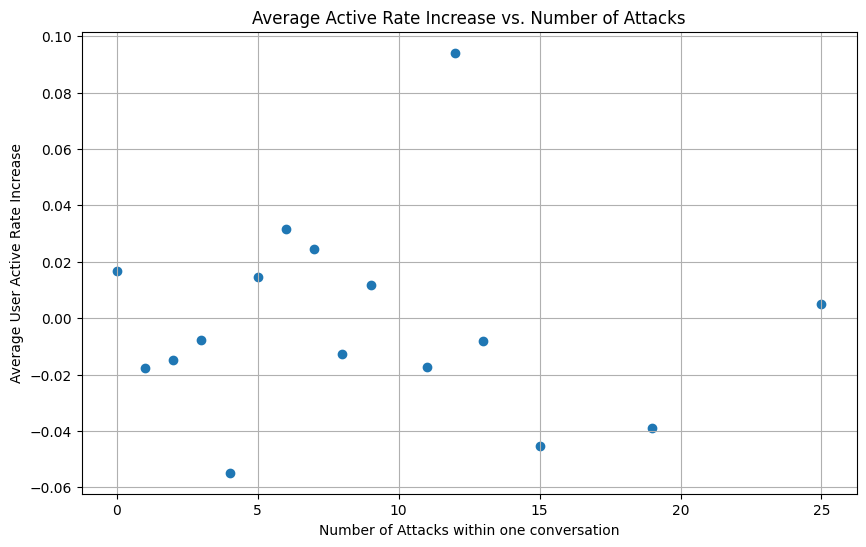

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(results["NumAttacks"], results["AverageActiveRateChange"])
plt.xlabel("Number of Attacks within one conversation")
plt.ylabel("Average User Active Rate Increase")
plt.title("Average Active Rate Increase vs. Number of Attacks")
plt.grid(True)
plt.show()

# Multi Variable Regression

## IV: Previous acitivity
Independent Variables:
1. Number of toxic comments
2. Active rate of the user before conversation

Dependent Variable:
1. Active rate change after conversation

Linear Regression Model: https://scipy-lectures.org/packages/statistics/auto_examples/plot_regression_3d.html

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/capstone/comments_article_2015/comments_article_2015_with_predictions.tsv', delimiter='\t')

In [ ]:
grouped = df.groupby("page_id")["is_attack"].sum()
filtered_df = df[df["page_id"].isin(grouped[grouped > 0].index)]

print("Number of comments left:")
print(len(filtered_df))
print("Number of pages left:")
print(len(filtered_df['page_id'].unique()))

Number of comments left:
163097
Number of pages left:
2141


In [ ]:
# random sample some pages without toxic comments
grouped = df.groupby("page_id")["is_attack"].sum()
filtered_df = df[df["page_id"].isin(grouped[grouped > 0].index)]
zero_attack_pages = grouped[grouped == 0].index

# Step 2: Randomly sample 2000 of these pages
random_sample_size = 2141
sampled_pages = np.random.choice(zero_attack_pages, size=random_sample_size, replace=False)

# Step 3: Concatenate the sampled pages to 'filtered_df'
sampled_df = df[df["page_id"].isin(sampled_pages)]
filtered_df = pd.concat([filtered_df, sampled_df])

print("Number of comments left:")
print(len(filtered_df))
print("Number of pages left:")
print(len(filtered_df['page_id'].unique()))

Number of comments left:
170982
Number of pages left:
4282


In [ ]:
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

grouped = filtered_df.groupby(['page_id', 'user_id'])

# Function to calculate the change of active days rate for a specific user in a page.
# group parameter is the group that has been grouped by page_id and user_id
def calculate_active_rate_change(group, user_id):
    page_start_time = group['timestamp'].min()
    page_end_time = group['timestamp'].max()

    window_start_before = page_start_time - pd.DateOffset(months=6)
    window_end_after = page_end_time + pd.DateOffset(months=6)

    # active days is calculated using the original df instead of the filtered one.
    # Since we are interested in the user's activity in non toxic pages as well.
    active_days_before = df[(df['user_id'] == user_id) & (df['timestamp'] >= window_start_before) & (df['timestamp'] < page_start_time)]['timestamp'].dt.date.nunique()
    active_days_after = df[(df['user_id'] == user_id) & (df['timestamp'] > page_end_time) & (df['timestamp'] <= window_end_after)]['timestamp'].dt.date.nunique()

    if ((page_start_time.replace(tzinfo=None) - pd.to_datetime('2015-01-01').replace(tzinfo=None)).days == 0) or ((pd.to_datetime('2015-12-31').replace(tzinfo=None) - page_end_time.replace(tzinfo=None)).days == 0):
      return None
    active_rate_before = active_days_before / (page_start_time.replace(tzinfo=None) - pd.to_datetime('2015-01-01').replace(tzinfo=None)).days
    active_rate_after = active_days_after / (pd.to_datetime('2015-12-31').replace(tzinfo=None) - page_end_time.replace(tzinfo=None)).days

    toxic_comment_num = group["is_attack"].sum()

    return active_rate_before, active_rate_after - active_rate_before, toxic_comment_num

In [ ]:
each_page_user_change = grouped.apply(lambda x: calculate_active_rate_change(x, x.name[1]))

In [ ]:
each_page_user_change

page_id   user_id   
722       140946.0         (0.22448979591836735, -0.03340699337059663, 0)
          276665.0        (0.005988023952095809, 0.028494734668593848, 0)
          2673156.0      (0.13503649635036497, -0.0008901548869503229, 0)
          4936590.0                       (1.0, -0.011363636363636354, 0)
          7764849.0         (0.6538461538461539, -0.09345968041620212, 0)
                                              ...                        
48936947  19269270.0          (0.3839779005524862, 1.6160220994475138, 0)
48947765  1938651.0                                                  None
48955603  13659550.0                                                 None
48957259  114108.0      (0.0027472527472527475, -0.0027472527472527475...
48967400  327289.0           (0.3324175824175824, -1.3324175824175823, 0)
Length: 26616, dtype: object

In [ ]:
rst_df = each_page_user_change.reset_index().dropna()
rst_df[["active_rate_before", "active_rate_change", "toxic_count_before_user_last_comment"]] = rst_df[0].to_list()
rst_df = rst_df.drop(0, axis=1)
rst_df

,page_id,user_id,active_rate_before,active_rate_change,toxic_count_before_user_last_comment
0,722,140946.0,0.224490,-0.033407,0.0
1,722,276665.0,0.005988,0.028495,0.0
2,722,2673156.0,0.135036,-0.000890,0.0
3,722,4936590.0,1.000000,-0.011364,0.0
4,722,7764849.0,0.653846,-0.093460,0.0
...,...,...,...,...,...
26609,48930977,2901026.0,0.024931,-0.024931,0.0
26610,48936076,18431180.0,0.011080,0.488920,0.0
26611,48936947,19269270.0,0.383978,1.616022,0.0
26614,48957259,114108.0,0.002747,-0.002747,0.0


In [ ]:
page_attacks = filtered_df.groupby("page_id")["is_attack"].sum()
page_attacks

page_id
722         1
1803        1
2066        1
2301        3
2545        1
           ..
48936947    0
48947765    0
48955603    0
48957259    0
48967400    0
Name: is_attack, Length: 4282, dtype: int64

In [ ]:
rst_df = rst_df.join(page_attacks, on="page_id").rename(columns={"is_attack": "toxic_count_all"})

In [ ]:
rst_df

,page_id,user_id,active_rate_before,active_rate_change,toxic_count_before_user_last_comment,toxic_count_all
0,722,140946.0,0.224490,-0.033407,0.0,1
1,722,276665.0,0.005988,0.028495,0.0,1
2,722,2673156.0,0.135036,-0.000890,0.0,1
3,722,4936590.0,1.000000,-0.011364,0.0,1
4,722,7764849.0,0.653846,-0.093460,0.0,1
...,...,...,...,...,...,...
26609,48930977,2901026.0,0.024931,-0.024931,0.0,0
26610,48936076,18431180.0,0.011080,0.488920,0.0,0
26611,48936947,19269270.0,0.383978,1.616022,0.0,0
26614,48957259,114108.0,0.002747,-0.002747,0.0,0


In [ ]:
rst_df["toxic_count_all"].value_counts()

1     13160
2      3620
0      3485
3      2140
4       746
25      729
5       547
11      278
6       262
15      261
8       244
13      241
9       212
7       136
19      127
12      126
Name: toxic_count_all, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
# For 3d plots. This import is necessary to have 3D plotting below
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm

<Axes3D: xlabel='toxic_count_all', ylabel='active_rate_before', zlabel='active_rate_change'>

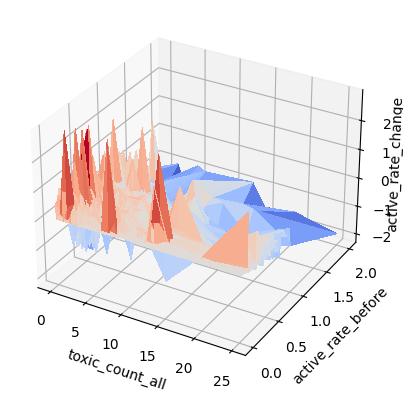

In [ ]:
X = rst_df["toxic_count_all"].to_list()
Y = rst_df["active_rate_before"].to_list()
Z = rst_df["active_rate_change"].to_list()
ax = plt.axes(projection='3d')
ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=False, cmap=plt.cm.coolwarm)
ax.set_xlabel('toxic_count_all')
ax.set_ylabel('active_rate_before')
ax.set_zlabel('active_rate_change')
ax.zaxis.labelpad = -5.0
ax

In [ ]:
model = ols("active_rate_change ~ toxic_count_all + active_rate_before", rst_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     active_rate_change   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     2410.
Date:                Fri, 27 Oct 2023   Prob (F-statistic):               0.00
Time:                        05:34:06   Log-Likelihood:                 775.25
No. Observations:               26314   AIC:                            -1545.
Df Residuals:                   26311   BIC:                            -1520.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0777      0

Interpretation of Statistics: https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a

In [ ]:
print("\nRetrieving manually the parameter estimates:")
print(model._results.params)


Retrieving manually the parameter estimates:
[ 0.07771425 -0.00238997 -0.32396449]


active_rate_change = 0.07771425 - 0.00238997 * toxic_count_all - 0.32396449 * active_rate_before

In [ ]:
# Peform analysis of variance on fitted linear model
anova_results = anova_lm(model)
print('\nANOVA results')
print(anova_results)


ANOVA results
                         df       sum_sq     mean_sq            F    PR(>F)
toxic_count_all         1.0     0.134429    0.134429     2.435046  0.118662
active_rate_before      1.0   265.952042  265.952042  4817.460805  0.000000
Residual            26311.0  1452.521249    0.055206          NaN       NaN


The lower the p value is for a given ratio, the more reliably we can reject the null hypothesis that a particular source or model or parameter is not significant.

### Discussion
1. The dependent variable here the active_rate_change, namely, active_rate_after - active_rate_before. It may cause some problems because the higher active_rate_before is, the higher active_rate_change tends to be. A more reasonable way is to derive the percentage of change instead of absolute values, but how to deal with the cases that active_rate_before = 0?


TODO:
(propensity score matching)

change the analysis code to consider the time factor (might need to do some extra preprocess of data to form the conversation data with at each timesteamp)

## IV: previous activity + time window

Data row for one article split to mutiple rows, each row represents a time window after the article. For instance, first month after, second month after, etc. Activity rate is then calculated within that time window.

Independent Variables:
1. Number of toxic comments
2. Previous time window ($T_{n-1}$) activity rate

Dependent Variable:
1. Next time window ($T_{n}$) activity rate

Time window size we define as one month = 30 days.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/capstone/comments_article_2015/comments_article_2015_with_predictions.tsv', delimiter='\t')

In [ ]:
# random sample some pages without toxic comments
grouped = df.groupby("page_id")["is_attack"].sum()
filtered_df = df[df["page_id"].isin(grouped[grouped > 0].index)]
zero_attack_pages = grouped[grouped == 0].index

# Step 2: Randomly sample 2000 of these pages
random_sample_size = 2141
sampled_pages = np.random.choice(zero_attack_pages, size=random_sample_size, replace=False)

# Step 3: Concatenate the sampled pages to 'filtered_df'
sampled_df = df[df["page_id"].isin(sampled_pages)]
filtered_df = pd.concat([filtered_df, sampled_df])

print("Number of comments left:")
print(len(filtered_df))
print("Number of pages left:")
print(len(filtered_df['page_id'].unique()))

Number of comments left:
170595
Number of pages left:
4282


In [ ]:
filtered_df.head()

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,bot,admin,predicted_prob,is_attack
0,641129549,NEWLINENEWLINE== SOCK PUPPETRY IS AWESOME! ==N...,NEWLINENEWLINE== SOCK PUPPETRY IS AWESOME! ==N...,2015-01-05T19:45:12Z,5030553,Main Page,NaN,2600:1014:B06C:71B5:0:47:77E4:1201,0,0,0.225735,0
1,643507658,I'm sorry if you felt uncomfortable after seei...,I'm sorry if you felt uncomfortable after seei...,2015-01-21T11:48:47Z,5030553,Main Page,1843661.0,Bencherlite,0,0,0.012484,0
2,643784998,you all disappeared from the future without a ...,you all disappeared from the future without a ...,2015-01-23T06:47:23Z,5030553,Main Page,NaN,75.175.22.86,0,0,0.151770,0
3,645180012,NEWLINENEWLINE== about me ==NEWLINENEWLINEI am...,NEWLINENEWLINE== about me ==NEWLINENEWLINEI am...,2015-02-01T16:56:54Z,5030553,Main Page,23975929.0,Parvez Iqbal,0,0,0.024715,0
4,645320587,NEWLINENEWLINE== umm ==NEWLINENEWLINEdhiraj,NEWLINENEWLINE== umm ==NEWLINENEWLINEdhiraj [[...,2015-02-02T16:14:39Z,5030553,Main Page,23985849.0,Dhiraj basyal,0,0,0.047766,0


In [ ]:
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

grouped = filtered_df.groupby(['page_id', 'user_id'])

# Function to get the number of months (30 days) after end of an article
# Index start from 0
# If last window size is less than 30 days, still going to return it
# During active rate calculation, treat last window size as up until last day of 2015.
def calculate_active_rate_change(group, user_id):
    page_end_time = group['timestamp'].max()
    month_diff = (pd.to_datetime('2015-12-31').replace(tzinfo=None) - page_end_time.replace(tzinfo=None)).days/30
    return range(math.ceil(month_diff))

In [ ]:
each_page_month_window = grouped.apply(lambda x: calculate_active_rate_change(x, x.name[1]))

In [ ]:
each_page_month_window

page_id   user_id   
722       140946.0      (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
          276665.0                                     (0)
          2673156.0                              (0, 1, 2)
          4936590.0                              (0, 1, 2)
          7764849.0                  (0, 1, 2, 3, 4, 5, 6)
                                       ...                
48943387  196153.0                                     (0)
48954807  2766075.0                                     ()
48955980  64853.0                                       ()
48966018  800198.0                                      ()
48967706  20315468.0                                    ()
Length: 26454, dtype: object

How many number of months window do we have for each page after it ends? Following is a value_counts on that.

In [ ]:
print("First column is number of month window (30 days window) each page have after it ends. Second column is number of pages that fall into first column")
each_page_month_window.apply(len).value_counts()

First column is number of month window (30 days window) each page have after it ends. Second column is number of pages that fall into first column


1     2585
2     2580
3     2344
5     2304
4     2229
12    2074
11    2050
10    2041
7     2010
6     1952
8     1938
9     1897
0      309
13     141
dtype: int64

In [ ]:
window_df = each_page_month_window.reset_index()
window_df["month_window_after"] = window_df[0]
window_df = window_df.drop(0, axis=1)
window_df = window_df.explode("month_window_after")
window_df = window_df.dropna()
window_df

,page_id,user_id,month_window_after
0,722,140946.0,0
0,722,140946.0,1
0,722,140946.0,2
0,722,140946.0,3
0,722,140946.0,4
...,...,...,...
26444,48921017,5207410.0,0
26445,48928776,9491027.0,0
26447,48932533,25154634.0,0
26448,48937926,10856267.0,0


In [ ]:
filtered_window_df = window_df.merge(filtered_df, on=["page_id", "user_id"], how="left")

In [ ]:
filtered_window_df

,page_id,user_id,month_window_after,rev_id,comment,raw_comment,timestamp,page_title,user_text,bot,admin,predicted_prob,is_attack
0,722,140946.0,0,647882981,"NEWLINE::Luckily, this is an encyclopedia, not...","NEWLINE::Luckily, this is an encyclopedia, not...",2015-02-19 14:46:08+00:00,Animal,Dinoguy2,0,0,0.029640,0
1,722,140946.0,1,647882981,"NEWLINE::Luckily, this is an encyclopedia, not...","NEWLINE::Luckily, this is an encyclopedia, not...",2015-02-19 14:46:08+00:00,Animal,Dinoguy2,0,0,0.029640,0
2,722,140946.0,2,647882981,"NEWLINE::Luckily, this is an encyclopedia, not...","NEWLINE::Luckily, this is an encyclopedia, not...",2015-02-19 14:46:08+00:00,Animal,Dinoguy2,0,0,0.029640,0
3,722,140946.0,3,647882981,"NEWLINE::Luckily, this is an encyclopedia, not...","NEWLINE::Luckily, this is an encyclopedia, not...",2015-02-19 14:46:08+00:00,Animal,Dinoguy2,0,0,0.029640,0
4,722,140946.0,4,647882981,"NEWLINE::Luckily, this is an encyclopedia, not...","NEWLINE::Luckily, this is an encyclopedia, not...",2015-02-19 14:46:08+00:00,Animal,Dinoguy2,0,0,0.029640,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
690083,48928776,9491027.0,0,697294328,"""NEWLINENEWLINE== Problems ==NEWLINENEWLINE Th...","""NEWLINENEWLINE== Problems ==NEWLINENEWLINE{{P...",2015-12-29 15:18:57+00:00,1905 University of Florida Blue and White foot...,Dirtlawyer1,0,0,0.001971,0
690084,48928776,9491027.0,0,697294565,Grouping the 1905 season with the FAC/UFLC tea...,Grouping the 1905 season with the FAC/UFLC tea...,2015-12-29 15:20:39+00:00,1905 University of Florida Blue and White foot...,Dirtlawyer1,0,0,0.007211,0
690085,48932533,25154634.0,0,697143144,REDIRECT Talk:One Day International matches re...,#REDIRECT [[Talk:One Day International matches...,2015-12-28 15:05:32+00:00,One Day International matches results (2005-09),GreenCricket,0,0,0.008760,0
690086,48937926,10856267.0,0,697240339,creating station stub,creating station stub [[User:Darren Zhang|Dar...,2015-12-29 05:14:01+00:00,Central Market BRT station,Darren Zhang,0,0,0.029050,0


### After explosion to multiple time windows

In [ ]:
import datetime

filtered_window_df['timestamp'] = pd.to_datetime(filtered_window_df['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

grouped = filtered_window_df.groupby(['page_id', 'user_id', "month_window_after"])

def calculate_active_rate_change(group, user_id, month_window_after):
    page_end_time = group['timestamp'].max()

    month_window_after = int(month_window_after)

    prev_window_start = page_end_time + datetime.timedelta(days=30*(month_window_after-1))
    prev_window_end = page_end_time + datetime.timedelta(days=30*month_window_after)

    window_start = page_end_time + datetime.timedelta(days=30*month_window_after)
    window_end = page_end_time + datetime.timedelta(days=30*(month_window_after+1))

    # TODO: change iv and dv calculation after here


    # active days is calculated using the original df instead of the filtered one.
    # Since we are interested in the user's activity in non toxic pages as well.
    if (prev_window_start.replace(tzinfo=None) - pd.to_datetime('2015-01-01').replace(tzinfo=None)).days < 0  or (pd.to_datetime('2015-12-31').replace(tzinfo=None) - window_end.replace(tzinfo=None)).days < 0:
      return None


    prev_active_days = df[(df['user_id'] == user_id) & (df['timestamp'] >= prev_window_start) & (df['timestamp'] < prev_window_end)]['timestamp'].dt.date.nunique()
    cur_active_days = df[(df['user_id'] == user_id) & (df['timestamp'] >= window_start) & (df['timestamp'] < window_end)]['timestamp'].dt.date.nunique()

    prev_active_rate = prev_active_days / 30
    cur_active_rate = cur_active_days / 30

    return prev_active_rate, cur_active_rate

In [ ]:
each_page_user_change = grouped.apply(lambda x: calculate_active_rate_change(x, x.name[1], x.name[2]))
each_page_user_change

page_id   user_id     month_window_after
722       140946.0    0                                    (0.13333333333333333, 0.4)
                      1                                                    (0.4, 0.4)
                      2                                                    (0.4, 0.4)
                      3                                     (0.4, 0.3333333333333333)
                      4                     (0.3333333333333333, 0.36666666666666664)
                                                              ...                    
48921017  5207410.0   0                                                          None
48928776  9491027.0   0                                                          None
48932533  25154634.0  0                                                          None
48937926  10856267.0  0                                                          None
48943387  196153.0    0                                                          None
Length: 16325

In [ ]:
rst_df = each_page_user_change.reset_index().dropna()
rst_df[["prev_active_rate", "cur_active_rate"]] = rst_df[0].to_list()
rst_df = rst_df.drop(0, axis=1)
rst_df

,page_id,user_id,month_window_after,prev_active_rate,cur_active_rate
0,722,140946.0,0,0.133333,0.400000
1,722,140946.0,1,0.400000,0.400000
2,722,140946.0,2,0.400000,0.400000
3,722,140946.0,3,0.400000,0.333333
4,722,140946.0,4,0.333333,0.366667
...,...,...,...,...,...
163023,48671770,26914453.0,0,0.000000,0.033333
163025,48676497,17652082.0,0,0.133333,0.233333
163027,48676497,23379190.0,0,0.000000,0.033333
163029,48687138,15484855.0,0,0.300000,0.600000


In [ ]:
page_attacks = filtered_df.groupby("page_id")["is_attack"].sum()
page_attacks

page_id
722         1
1803        1
2066        1
2301        3
2498        0
           ..
48943387    0
48954807    0
48955980    0
48966018    0
48967706    0
Name: is_attack, Length: 4282, dtype: int64

In [ ]:
rst_df = rst_df.join(page_attacks, on="page_id").rename(columns={"is_attack": "toxicity"})
rst_df = rst_df.join(page_attacks, on="page_id")
rst_df

,page_id,user_id,month_window_after,prev_active_rate,cur_active_rate,toxicity,is_attack
0,722,140946.0,0,0.133333,0.400000,1,1
1,722,140946.0,1,0.400000,0.400000,1,1
2,722,140946.0,2,0.400000,0.400000,1,1
3,722,140946.0,3,0.400000,0.333333,1,1
4,722,140946.0,4,0.333333,0.366667,1,1
...,...,...,...,...,...,...,...
163023,48671770,26914453.0,0,0.000000,0.033333,0,0
163025,48676497,17652082.0,0,0.133333,0.233333,0,0
163027,48676497,23379190.0,0,0.000000,0.033333,0,0
163029,48687138,15484855.0,0,0.300000,0.600000,0,0


In [ ]:
rst_df["toxicity"].value_counts()

1     69547
0     17693
2     17590
3     11336
25     3949
4      3378
5      2556
9      2013
15     1872
11     1558
6      1413
13     1389
19      595
8       379
7       340
12      286
Name: toxicity, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
# For 3d plots. This import is necessary to have 3D plotting below
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm

### DV: toxicity + prev_active_rate

<Axes3D: xlabel='toxicity', ylabel='prev_active_rate', zlabel='cur_active_rate'>

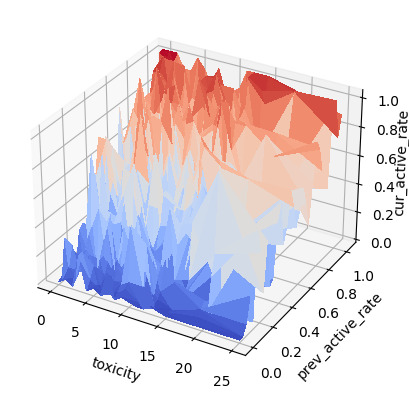

In [ ]:
X = rst_df["toxicity"].to_list()
Y = rst_df["prev_active_rate"].to_list()
Z = rst_df["cur_active_rate"].to_list()
ax = plt.axes(projection='3d')
ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=False, cmap=plt.cm.coolwarm)
ax.set_xlabel('toxicity')
ax.set_ylabel('prev_active_rate')
ax.set_zlabel('cur_active_rate')
ax.zaxis.labelpad = -2.0
ax

In [ ]:
model = ols("cur_active_rate ~ toxicity + prev_active_rate", rst_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        cur_active_rate   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                 3.008e+05
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:56:24   Log-Likelihood:                 76415.
No. Observations:              135894   AIC:                        -1.528e+05
Df Residuals:                  135891   BIC:                        -1.528e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0163      0.001  

In [ ]:
print("\nRetrieving manually the parameter estimates:")
print(model._results.params)


Retrieving manually the parameter estimates:
[ 0.01625432 -0.0009545   0.890632  ]


cur_active_rate = 0.016 - 0.001 * toxicity + 0.89 * prev_active_rate

In [ ]:
# Peform analysis of variance on fitted linear model
# The lower the p value is for a given ratio, the more reliably we can reject the null hypothesis that a particular source or model or parameter is not significant.
anova_results = anova_lm(model)
print('\nANOVA results')
print(anova_results)


ANOVA results
                        df        sum_sq       mean_sq              F  PR(>F)
toxicity               1.0    343.068713    343.068713   18041.054916     0.0
prev_active_rate       1.0  11095.589134  11095.589134  583486.995680     0.0
Residual          135891.0   2584.103355      0.019016            NaN     NaN


### DV: toxicity + prev_active_rate + time * toxicity

In [ ]:
rst_df

,page_id,user_id,month_window_after,prev_active_rate,cur_active_rate,toxicity,is_attack
0,722,140946.0,0,0.133333,0.400000,1,1
1,722,140946.0,1,0.400000,0.400000,1,1
2,722,140946.0,2,0.400000,0.400000,1,1
3,722,140946.0,3,0.400000,0.333333,1,1
4,722,140946.0,4,0.333333,0.366667,1,1
...,...,...,...,...,...,...,...
163023,48671770,26914453.0,0,0.000000,0.033333,0,0
163025,48676497,17652082.0,0,0.133333,0.233333,0,0
163027,48676497,23379190.0,0,0.000000,0.033333,0,0
163029,48687138,15484855.0,0,0.300000,0.600000,0,0


In [ ]:
rst_df["time_X_toxicity"] = rst_df["month_window_after"] * rst_df["toxicity"]
rst_df

,page_id,user_id,month_window_after,prev_active_rate,cur_active_rate,toxicity,is_attack,time_X_toxicity
0,722,140946.0,0,0.133333,0.400000,1,1,0
1,722,140946.0,1,0.400000,0.400000,1,1,1
2,722,140946.0,2,0.400000,0.400000,1,1,2
3,722,140946.0,3,0.400000,0.333333,1,1,3
4,722,140946.0,4,0.333333,0.366667,1,1,4
...,...,...,...,...,...,...,...,...
163023,48671770,26914453.0,0,0.000000,0.033333,0,0,0
163025,48676497,17652082.0,0,0.133333,0.233333,0,0,0
163027,48676497,23379190.0,0,0.000000,0.033333,0,0,0
163029,48687138,15484855.0,0,0.300000,0.600000,0,0,0


In [ ]:
rst_df["time_X_toxicity"].value_counts()

0      36530
2      12395
1      10754
4      10355
3      10303
       ...  
190        5
143        4
80         3
275        3
209        1
Name: time_X_toxicity, Length: 86, dtype: int64

In [ ]:
model = ols("cur_active_rate ~ toxicity + prev_active_rate + time_X_toxicity", rst_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        cur_active_rate   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                 2.005e+05
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:03:02   Log-Likelihood:                 76421.
No. Observations:              135894   AIC:                        -1.528e+05
Df Residuals:                  135890   BIC:                        -1.528e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0162      0.001  

In [ ]:
print("\nRetrieving manually the parameter estimates:")
print(model._results.params)


Retrieving manually the parameter estimates:
[ 1.61945834e-02 -1.25962807e-03  8.90906152e-01  8.62324957e-05]


cur_active_rate = 0.016 - 0.0013 * toxicity + 0.89 * prev_active_rate + 8.62e-05 * time_X_toxicity

In [ ]:
# Peform analysis of variance on fitted linear model
anova_results = anova_lm(model)
print('\nANOVA results')
print(anova_results)


ANOVA results
                        df        sum_sq       mean_sq              F  \
toxicity               1.0    343.068713    343.068713   18042.586902   
prev_active_rate       1.0  11095.589134  11095.589134  583536.543428   
time_X_toxicity        1.0      0.238429      0.238429      12.539405   
Residual          135890.0   2583.864926      0.019014            NaN   

                    PR(>F)  
toxicity          0.000000  
prev_active_rate  0.000000  
time_X_toxicity   0.000399  
Residual               NaN  


Comments:
- Standardize all the variables
- Include time as a IV also
- Participation (not activity): count participation by number of tokens? instead of active days

Heuristics for witness:
- Short (24 hrs) time window, comment made after (about the same time)
- Same topic, similar content

Manually check first heuristic, if it works

# Corrected Multi Variable Regression
Participation rate: Average number of tokens the user contributes per day

Independent Variables:

1. Toxicity: number of toxic comments
2. Previous time window ( 𝑇𝑛−1 ) participation rate
3. Time (0, 1, 2, ...)
4. Interaction of time with toxicity: time X toxicity

Dependent Variable:

Current time window ( 𝑇𝑛 ) participation rate

Time window size we define as one month = 30 days.

All variables are standardized before model fitting.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/capstone/comments_article_2015/comments_article_2015_with_predictions.tsv', delimiter='\t')

In [ ]:
grouped = df.groupby("page_id")["is_attack"].sum()
filtered_df = df[df["page_id"].isin(grouped[grouped > 0].index)]

print("Number of comments left:")
print(len(filtered_df))
print("Number of pages left:")
print(len(filtered_df['page_id'].unique()))

Number of comments left:
163097
Number of pages left:
2141


In [ ]:
# random sample some pages without toxic comments
grouped = df.groupby("page_id")["is_attack"].sum()
filtered_df = df[df["page_id"].isin(grouped[grouped > 0].index)]
zero_attack_pages = grouped[grouped == 0].index

# Step 2: Randomly sample 2000 of these pages
random_sample_size = 2141
sampled_pages = np.random.choice(zero_attack_pages, size=random_sample_size, replace=False)

# Step 3: Concatenate the sampled pages to 'filtered_df'
sampled_df = df[df["page_id"].isin(sampled_pages)]
filtered_df = pd.concat([filtered_df, sampled_df])

print("Number of comments left:")
print(len(filtered_df))
print("Number of pages left:")
print(len(filtered_df['page_id'].unique()))

Number of comments left:
171879
Number of pages left:
4282


In [ ]:
# remove newline tokens
filtered_df['comment'] = filtered_df['comment'].apply(lambda x: x.replace("NEWLINE", " "))

In [ ]:
filtered_df.head()

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,bot,admin,predicted_prob,is_attack
0,641129549,== SOCK PUPPETRY IS AWESOME! == I am the gr...,NEWLINENEWLINE== SOCK PUPPETRY IS AWESOME! ==N...,2015-01-05T19:45:12Z,5030553,Main Page,NaN,2600:1014:B06C:71B5:0:47:77E4:1201,0,0,0.225735,0
1,643507658,I'm sorry if you felt uncomfortable after seei...,I'm sorry if you felt uncomfortable after seei...,2015-01-21T11:48:47Z,5030553,Main Page,1843661.0,Bencherlite,0,0,0.012484,0
2,643784998,you all disappeared from the future without a ...,you all disappeared from the future without a ...,2015-01-23T06:47:23Z,5030553,Main Page,NaN,75.175.22.86,0,0,0.151770,0
3,645180012,== about me == I am a student i read in cla...,NEWLINENEWLINE== about me ==NEWLINENEWLINEI am...,2015-02-01T16:56:54Z,5030553,Main Page,23975929.0,Parvez Iqbal,0,0,0.024715,0
4,645320587,== umm == dhiraj,NEWLINENEWLINE== umm ==NEWLINENEWLINEdhiraj [[...,2015-02-02T16:14:39Z,5030553,Main Page,23985849.0,Dhiraj basyal,0,0,0.047766,0


In [ ]:
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

grouped = filtered_df.groupby(['page_id', 'user_id'])

# Function to get the number of months (30 days) after end of an article
# Index start from 0
# If last window size is less than 30 days, still going to return it
# During active rate calculation, treat last window size as up until last day of 2015.
def calculate_active_rate_change(group, user_id):
    page_end_time = group['timestamp'].max()
    month_diff = (pd.to_datetime('2015-12-31').replace(tzinfo=None) - page_end_time.replace(tzinfo=None)).days/30
    return range(math.ceil(month_diff))

In [ ]:
import math
each_page_month_window = grouped.apply(lambda x: calculate_active_rate_change(x, x.name[1]))

In [ ]:
each_page_month_window

page_id   user_id   
722       140946.0      (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
          276665.0                                     (0)
          2673156.0                              (0, 1, 2)
          4936590.0                              (0, 1, 2)
          7764849.0                  (0, 1, 2, 3, 4, 5, 6)
                                       ...                
48944410  146242.0                                     (0)
48946033  7480926.0                                    (0)
48947098  2157954.0                                     ()
          4936590.0                                     ()
          27177901.0                                    ()
Length: 26679, dtype: object

In [ ]:
window_df = each_page_month_window.reset_index()
window_df["month_window_after"] = window_df[0]
window_df = window_df.drop(0, axis=1)
window_df = window_df.explode("month_window_after")
window_df = window_df.dropna()
window_df

,page_id,user_id,month_window_after
0,722,140946.0,0
0,722,140946.0,1
0,722,140946.0,2
0,722,140946.0,3
0,722,140946.0,4
...,...,...,...
26671,48934488,1164129.0,0
26672,48934488,4936590.0,0
26673,48937439,26030469.0,0
26674,48944410,146242.0,0


In [ ]:
filtered_window_df = window_df.merge(filtered_df, on=["page_id", "user_id"], how="left")

In [ ]:
filtered_window_df

,page_id,user_id,month_window_after,rev_id,comment,raw_comment,timestamp,page_title,user_text,bot,admin,predicted_prob,is_attack
0,722,140946.0,0,647882981,"::Luckily, this is an encyclopedia, not a dic...","NEWLINE::Luckily, this is an encyclopedia, not...",2015-02-19 14:46:08+00:00,Animal,Dinoguy2,0,0,0.029640,0
1,722,140946.0,1,647882981,"::Luckily, this is an encyclopedia, not a dic...","NEWLINE::Luckily, this is an encyclopedia, not...",2015-02-19 14:46:08+00:00,Animal,Dinoguy2,0,0,0.029640,0
2,722,140946.0,2,647882981,"::Luckily, this is an encyclopedia, not a dic...","NEWLINE::Luckily, this is an encyclopedia, not...",2015-02-19 14:46:08+00:00,Animal,Dinoguy2,0,0,0.029640,0
3,722,140946.0,3,647882981,"::Luckily, this is an encyclopedia, not a dic...","NEWLINE::Luckily, this is an encyclopedia, not...",2015-02-19 14:46:08+00:00,Animal,Dinoguy2,0,0,0.029640,0
4,722,140946.0,4,647882981,"::Luckily, this is an encyclopedia, not a dic...","NEWLINE::Luckily, this is an encyclopedia, not...",2015-02-19 14:46:08+00:00,Animal,Dinoguy2,0,0,0.029640,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
700426,48934488,1164129.0,0,697329095,""" ==Some notes for later== """"Faceva fare — ri...","""NEWLINENEWLINE==Some notes for later==NEWLINE...",2015-12-29 20:14:44+00:00,Arturo Melocchi,Trrill,0,0,0.018935,0
700427,48934488,4936590.0,0,697329256,""" — Preceding unsigned comment added by • """,""" <small><span class=""""autosigned"""">—&nbsp;Pr...",2015-12-29 20:15:59+00:00,Arturo Melocchi,SineBot,1,0,0.063151,0
700428,48937439,26030469.0,0,697233428,REDIRECT Talk:List of ethnic groups in the Uni...,#REDIRECT [[Talk:List of ethnic groups in the ...,2015-12-29 03:55:13+00:00,Per capita income in the United States by ance...,Filpro,0,0,0.004260,0
700429,48944410,146242.0,0,697324027,REDIRECT Talk:York High School (Virginia),#REDIRECT [[Talk:York High School (Virginia)]]...,2015-12-29 19:32:39+00:00,"York High School (Yorktown, Virginia)",BDD,0,0,0.013545,0


In [ ]:
import datetime

filtered_window_df['timestamp'] = pd.to_datetime(filtered_window_df['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

grouped = filtered_window_df.groupby(['page_id', 'user_id', "month_window_after"])

def calculate_participation_rate(group, user_id, month_window_after):
    page_end_time = group['timestamp'].max()

    month_window_after = int(month_window_after)

    prev_window_start = page_end_time + datetime.timedelta(days=30*(month_window_after-1))
    prev_window_end = page_end_time + datetime.timedelta(days=30*month_window_after)

    window_start = page_end_time + datetime.timedelta(days=30*month_window_after)
    window_end = page_end_time + datetime.timedelta(days=30*(month_window_after+1))

    if (prev_window_start.replace(tzinfo=None) - pd.to_datetime('2015-01-01').replace(tzinfo=None)).days < 0  or (pd.to_datetime('2015-12-31').replace(tzinfo=None) - window_end.replace(tzinfo=None)).days < 0:
      return None

    prev_participation = df[(df['user_id'] == user_id) & (df['timestamp'] >= prev_window_start) & (df['timestamp'] < prev_window_end)]["comment"].apply(lambda x: len(x.split())).sum()
    cur_participation = df[(df['user_id'] == user_id) & (df['timestamp'] >= window_start) & (df['timestamp'] < window_end)]["comment"].apply(lambda x: len(x.split())).sum()


    prev_participation_rate = prev_participation / 30
    cur_participation_rate = cur_participation / 30

    return prev_participation_rate, cur_participation_rate

In [ ]:
each_page_user_change = grouped.apply(lambda x: calculate_participation_rate(x, x.name[1], x.name[2]))
each_page_user_change

page_id   user_id     month_window_after
722       140946.0    0                                     (8.2, 34.43333333333333)
                      1                      (34.43333333333333, 53.233333333333334)
                      2                     (53.233333333333334, 27.333333333333332)
                      3                      (27.333333333333332, 44.36666666666667)
                      4                      (44.36666666666667, 52.333333333333336)
                                                              ...                   
48934488  1164129.0   0                                                         None
          4936590.0   0                                                         None
48937439  26030469.0  0                                                         None
48944410  146242.0    0                                                         None
48946033  7480926.0   0                                                         None
Length: 164731, dtype: o

In [ ]:
rst_df = each_page_user_change.reset_index().dropna()
rst_df[["prev_participation_rate", "cur_participation_rate"]] = rst_df[0].to_list()
rst_df = rst_df.drop(0, axis=1)
rst_df

,page_id,user_id,month_window_after,prev_participation_rate,cur_participation_rate
0,722,140946.0,0,8.200000,34.433333
1,722,140946.0,1,34.433333,53.233333
2,722,140946.0,2,53.233333,27.333333
3,722,140946.0,3,27.333333,44.366667
4,722,140946.0,4,44.366667,52.333333
...,...,...,...,...,...
164497,48668110,561624.0,0,18.333333,13.766667
164499,48677057,1617947.0,0,0.000000,0.400000
164501,48679231,2666701.0,0,210.433333,132.766667
164503,48679231,16532586.0,0,24.666667,194.500000


In [ ]:
page_attacks = filtered_df.groupby("page_id")["is_attack"].sum()
page_attacks

page_id
722         1
1024        0
1803        1
2066        1
2301        3
           ..
48934488    0
48937439    0
48944410    0
48946033    0
48947098    0
Name: is_attack, Length: 4282, dtype: int64

In [ ]:
rst_df = rst_df.join(page_attacks, on="page_id").rename(columns={"is_attack": "toxicity"})
rst_df = rst_df.join(page_attacks, on="page_id")
rst_df

,page_id,user_id,month_window_after,prev_participation_rate,cur_participation_rate,toxicity,is_attack
0,722,140946.0,0,8.200000,34.433333,1,1
1,722,140946.0,1,34.433333,53.233333,1,1
2,722,140946.0,2,53.233333,27.333333,1,1
3,722,140946.0,3,27.333333,44.366667,1,1
4,722,140946.0,4,44.366667,52.333333,1,1
...,...,...,...,...,...,...,...
164497,48668110,561624.0,0,18.333333,13.766667,0,0
164499,48677057,1617947.0,0,0.000000,0.400000,0,0
164501,48679231,2666701.0,0,210.433333,132.766667,0,0
164503,48679231,16532586.0,0,24.666667,194.500000,0,0


In [ ]:
def normalize_cols(df, cols):
  for col in cols:
    df[col] = (df[col] - df[col].mean()) / df[col].std()
  return df

# standarize all the dependant variables
rst_df = normalize_cols(rst_df, ["prev_participation_rate", "month_window_after", "cur_participation_rate", "toxicity"])
rst_df

,page_id,user_id,month_window_after,prev_participation_rate,cur_participation_rate,toxicity,is_attack
0,722,140946.0,-1.243821,-0.167389,-0.147681,-0.359266,1
1,722,140946.0,-0.876137,-0.155726,-0.138693,-0.359266,1
2,722,140946.0,-0.508453,-0.147367,-0.151076,-0.359266,1
3,722,140946.0,-0.140769,-0.158882,-0.142932,-0.359266,1
4,722,140946.0,0.226915,-0.151309,-0.139123,-0.359266,1
...,...,...,...,...,...,...,...
164497,48668110,561624.0,-1.243821,-0.162883,-0.157562,-0.567427,0
164499,48677057,1617947.0,-1.243821,-0.171034,-0.163952,-0.567427,0
164501,48679231,2666701.0,-1.243821,-0.077478,-0.100668,-0.567427,0
164503,48679231,16532586.0,-1.243821,-0.160068,-0.071154,-0.567427,0


In [ ]:
rst_df["time_X_toxicity"] = rst_df["month_window_after"] * rst_df["toxicity"]
rst_df = rst_df.rename(columns={"month_window_after": "time"})

In [ ]:
rst_df

,page_id,user_id,time,prev_participation_rate,cur_participation_rate,toxicity,is_attack,time_X_toxicity
0,722,140946.0,-1.243821,-0.167389,-0.147681,-0.359266,1,0.446863
1,722,140946.0,-0.876137,-0.155726,-0.138693,-0.359266,1,0.314767
2,722,140946.0,-0.508453,-0.147367,-0.151076,-0.359266,1,0.182670
3,722,140946.0,-0.140769,-0.158882,-0.142932,-0.359266,1,0.050574
4,722,140946.0,0.226915,-0.151309,-0.139123,-0.359266,1,-0.081523
...,...,...,...,...,...,...,...,...
164497,48668110,561624.0,-1.243821,-0.162883,-0.157562,-0.567427,0,0.705778
164499,48677057,1617947.0,-1.243821,-0.171034,-0.163952,-0.567427,0,0.705778
164501,48679231,2666701.0,-1.243821,-0.077478,-0.100668,-0.567427,0,0.705778
164503,48679231,16532586.0,-1.243821,-0.160068,-0.071154,-0.567427,0,0.705778


In [ ]:
import matplotlib.pyplot as plt
# For 3d plots. This import is necessary to have 3D plotting below
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm

In [ ]:
model = ols("cur_participation_rate ~ prev_participation_rate + time + toxicity + time_X_toxicity", rst_df).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     cur_participation_rate   R-squared:                       0.762
Model:                                OLS   Adj. R-squared:                  0.762
Method:                     Least Squares   F-statistic:                 1.096e+05
Date:                    Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                            07:32:55   Log-Likelihood:                -96214.
No. Observations:                  137118   AIC:                         1.924e+05
Df Residuals:                      137113   BIC:                         1.925e+05
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [ ]:
print("\nRetrieving manually the parameter estimates:")
print(model._results.params)


Retrieving manually the parameter estimates:
[-9.93690583e-07  8.72519528e-01 -1.10482671e-03 -3.93332203e-03
  4.66442243e-05]


1. p-value for the intercept is 0.999, for the time is 0.403 and for time_X_toxicity is 0.971, which is large. It shows that they're not a factor of current participation rate.
2. cur_participation_rate = 0.87 * prev_participation_rate - 0.0039 * toxicity


In [ ]:
# Peform analysis of variance on fitted linear model
anova_results = anova_lm(model)
print('\nANOVA results')
print(anova_results)


ANOVA results
                               df         sum_sq        mean_sq  \
prev_participation_rate       1.0  104448.335298  104448.335298   
time                          1.0       0.189520       0.189520   
toxicity                      1.0       2.112053       2.112053   
time_X_toxicity               1.0       0.000308       0.000308   
Residual                 137113.0   32666.362821       0.238244   

                                     F    PR(>F)  
prev_participation_rate  438408.912436  0.000000  
time                          0.795486  0.372448  
toxicity                      8.865080  0.002907  
time_X_toxicity               0.001292  0.971327  
Residual                           NaN       NaN  


Robustness Comments:
0. Robustness check for 24hr/48hr/72hr window etc.
1. Use the 24 hr heurstic to filter 15 years of dataset

Regression comments:
2. Correct calculation of number of tokens
3. Add more interactions: (Attacker, Target, Bystander) features, Heavy/light contributor
4. Examine threads to get some heuristics about who is the target: target could be the one just before (small window?) the toxic comment?
5. Hierachy linear regression: thread nested within pages. Not-independent

Propensity score matching comments:
5. Dependent variable right now is contribution to comments in talk page, so we should be controlling something that's influencing the thread, namely features of talk pages instead of articles. If we are analyzing contribution to article, then we need article features.
6. Match control groups: toxic and non-toxic threads are in the same talk page.

# Multi Variable Regression on Threads (Partial)

Participation rate: Average number of tokens the user contributes per day

Independent Variables:

Toxicity: number of toxic comments
Previous time window ( 𝑇𝑛−1 ) participation rate
Time (0, 1, 2, ...)
Interaction of time with toxicity: time X toxicity
Dependent Variable:

Current time window ( 𝑇𝑛 ) participation rate

Time window size we define as one month = 30 days.

All variables are standardized before model fitting.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df_2014 = pd.read_csv('/content/drive/MyDrive/capstone/comments_article_2014/comments_article_2014_with_predictions.tsv', delimiter='\t')
df_2014

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,bot,admin,predicted_prob,is_attack
0,590031971,NEWLINENEWLINE== Ranking of Australia for acce...,NEWLINENEWLINE== Ranking of Australia for acce...,2014-01-10T05:11:10Z,1178331.0,Immigration to Australia,12215099.0,Bahudhara,0.0,0.0,0.005972,0
1,616373888,Talk header}}NEWLINE{{WikiProject Pop music,Talk header}}NEWLINE{{WikiProject Pop music,2014-07-10T13:32:37Z,1178528.0,Cass Elliot,7328338.0,Yobot,1.0,0.0,0.014110,0
2,637514892,"NEWLINE:::Indeed, but we now have a user tryin...","NEWLINE:::Indeed, but we now have a user tryin...",2014-12-10T19:55:42Z,1178695.0,Stephens Island wren,26606.0,Moriori,0.0,0.0,0.007586,0
3,603078706,(not to mention existing scroll-hogging verbi...,(not to mention existing scroll-hogging verbi...,2014-04-07T00:15:35Z,1178914.0,Anthony Callea,13176174.0,Manytexts,0.0,0.0,0.024283,0
4,626522277,"""NEWLINENEWLINE== I know that the Weather Chan...","""NEWLINENEWLINE== I know that the Weather Chan...",2014-09-21T20:22:28Z,1179500.0,The Weather Channel,18522464.0,Dustin V. S.,0.0,0.0,0.015316,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1150352,618072952,I have recently moved to Tasmania and feel ...,I have recently moved to Tasmania and feel ...,2014-07-23T03:55:55Z,43370421.0,"Cal Ripken, Sr./GA1",4373394.0,CutOffTies,0.0,0.0,0.000753,0
1150353,618071243,REDIRECT Talk:King's Garden (Jerusalem)NEWLINE,#REDIRECT [[Talk:King's Garden (Jerusalem)]]NE...,2014-07-23T03:37:03Z,43370436.0,King's Garden,4564448.0,Rosiestep,0.0,0.0,0.008915,0
1150354,638143169,Ship sinks off ChinaNEWLINENEWLINE,*[http://www.tradewindsnews.com/casualties/341...,2014-12-15T03:53:05Z,43370922.0,Typhoon Matmo (2014),6479619.0,Cyclonebiskit,0.0,0.0,0.176582,0
1150355,630358429,NEWLINE:::I'm sure someone will if this RM fai...,NEWLINE:::I'm sure someone will if this RM fai...,2014-10-20T10:34:29Z,43371995.0,Jesus piece (jewelry),8846.0,Andrewa,0.0,0.0,0.014554,0


In [ ]:
df_2015 = pd.read_csv('/content/drive/MyDrive/capstone/comments_article_2015/comments_article_2015_with_predictions.tsv', delimiter='\t')
df_2015

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,bot,admin,predicted_prob,is_attack
0,641129549,NEWLINENEWLINE== SOCK PUPPETRY IS AWESOME! ==N...,NEWLINENEWLINE== SOCK PUPPETRY IS AWESOME! ==N...,2015-01-05T19:45:12Z,5030553,Main Page,NaN,2600:1014:B06C:71B5:0:47:77E4:1201,0,0,0.225735,0
1,643507658,I'm sorry if you felt uncomfortable after seei...,I'm sorry if you felt uncomfortable after seei...,2015-01-21T11:48:47Z,5030553,Main Page,1843661.0,Bencherlite,0,0,0.012484,0
2,643784998,you all disappeared from the future without a ...,you all disappeared from the future without a ...,2015-01-23T06:47:23Z,5030553,Main Page,NaN,75.175.22.86,0,0,0.151770,0
3,645180012,NEWLINENEWLINE== about me ==NEWLINENEWLINEI am...,NEWLINENEWLINE== about me ==NEWLINENEWLINEI am...,2015-02-01T16:56:54Z,5030553,Main Page,23975929.0,Parvez Iqbal,0,0,0.024715,0
4,645320587,NEWLINENEWLINE== umm ==NEWLINENEWLINEdhiraj,NEWLINENEWLINE== umm ==NEWLINENEWLINEdhiraj [[...,2015-02-02T16:14:39Z,5030553,Main Page,23985849.0,Dhiraj basyal,0,0,0.047766,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1182945,697545472,"""NEWLINE*Oppose: per comment results:NEWLINE:C...","""NEWLINE*'''Oppose''': per comment results:NEW...",2015-12-31T05:02:57Z,48173272,Israeli–Palestinian conflict (2015–present),6134854.0,Otr500,0,0,0.001692,0
1182946,685269511,NEWLINE:They are ;-). Thanks for correcting it...,NEWLINE:They are ;-). Thanks for correcting it...,2015-10-11T21:57:30Z,48173351,Trans-Pacific Strategic Economic Partnership A...,5705213.0,L.tak,0,0,0.013957,0
1182947,685269467,REDIRECT Talk:Henry Widdrington (died 1665)NEW...,#REDIRECT [[Talk:Henry Widdrington (died 1665)...,2015-10-11T21:57:05Z,48173583,Henry Widdrington,7098284.0,Tassedethe,0,0,0.009036,0
1182948,685292390,NEWLINEI have only corrected the grammar and b...,NEWLINEI have only corrected the grammar and b...,2015-10-12T01:05:35Z,48175896,Alias Pink Puzz,26444300.0,Tombrady33,0,0,0.003676,0


In [ ]:
df = pd.concat([df_2014, df_2015])
df = df[["user_id", "timestamp", "comment"]]
df

,user_id,timestamp,comment
0,12215099.0,2014-01-10T05:11:10Z,NEWLINENEWLINE== Ranking of Australia for acce...
1,7328338.0,2014-07-10T13:32:37Z,Talk header}}NEWLINE{{WikiProject Pop music
2,26606.0,2014-12-10T19:55:42Z,"NEWLINE:::Indeed, but we now have a user tryin..."
3,13176174.0,2014-04-07T00:15:35Z,(not to mention existing scroll-hogging verbi...
4,18522464.0,2014-09-21T20:22:28Z,"""NEWLINENEWLINE== I know that the Weather Chan..."
...,...,...,...
1182945,6134854.0,2015-12-31T05:02:57Z,"""NEWLINE*Oppose: per comment results:NEWLINE:C..."
1182946,5705213.0,2015-10-11T21:57:30Z,NEWLINE:They are ;-). Thanks for correcting it...
1182947,7098284.0,2015-10-11T21:57:05Z,REDIRECT Talk:Henry Widdrington (died 1665)NEW...
1182948,26444300.0,2015-10-12T01:05:35Z,NEWLINEI have only corrected the grammar and b...


In [ ]:
filtered_df = pd.read_csv('/content/drive/MyDrive/capstone/filtered_threads.tsv', delimiter='\t')
filtered_df

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,admin,predicted_prob,is_attack,time_diff,page_total_comments,thread,thread_id
0,679434867,NEWLINENEWLINE==Spotty==NEWLINEPerfunctory and...,NEWLINENEWLINE==Spotty==NEWLINEPerfunctory and...,2015-09-04 15:19:36+00:00,11796.0,Frederick William I of Prussia,55169.0,Sca,0.0,0.014072,0,NaN,15,0,"(11796.0, 0)"
1,679435090,NEWLINENEWLINE==Spotty==NEWLINEPerfunctory and...,NEWLINENEWLINE==Spotty==NEWLINEPerfunctory and...,2015-09-04 15:21:19+00:00,11796.0,Frederick William I of Prussia,55169.0,Sca,0.0,0.014072,0,0 days 00:01:43,15,0,"(11796.0, 0)"
2,692967271,NEWLINENEWLINE== Wrong Name ==NEWLINENEWLINEWh...,NEWLINENEWLINE== Wrong Name ==NEWLINENEWLINEWh...,2015-11-29 15:19:46+00:00,11796.0,Frederick William I of Prussia,NaN,112.198.98.30,0.0,0.011230,0,85 days 23:58:27,15,1,"(11796.0, 1)"
3,692969484,"NEWLINE:Jeez Louise, this again. If you'd care...","NEWLINE:Jeez Louise, this again. If you'd care...",2015-11-29 15:39:18+00:00,11796.0,Frederick William I of Prussia,19338611.0,Zwerg Nase,0.0,0.030208,0,0 days 00:19:32,15,1,"(11796.0, 1)"
4,692983366,NEWLINENEWLINE::But British Royals are German....,NEWLINENEWLINE::But British Royals are German....,2015-11-29 17:35:15+00:00,11796.0,Frederick William I of Prussia,NaN,112.198.98.30,0.0,0.026665,0,0 days 01:55:57,15,1,"(11796.0, 1)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10482,696762551,December 2015 (UTC)NEWLINE*Comment - Article ...,December 2015 (UTC)NEWLINE*'''Comment''' - Ar...,2015-12-25 17:25:46+00:00,48711778.0,2015 San Bernardino attack,26926014.0,Parsley Man,0.0,0.014106,0,1 days 10:31:55,1598,0,"(48711778.0, 0)"
10483,696801331,Merge proposal 19 December 2015 NEWLINE,== Merge proposal 19 December 2015 ==NEWLINE,2015-12-26 01:17:16+00:00,48711778.0,2015 San Bernardino attack,2970138.0,WWGB,0.0,0.014830,0,0 days 07:51:30,1598,0,"(48711778.0, 0)"
10484,697647531,December 2015 (UTC)NEWLINE:::I agree that pri...,December 2015 (UTC)NEWLINE:::I agree that pri...,2015-12-31 21:56:06+00:00,48711778.0,2015 San Bernardino attack,303089.0,Nowa,0.0,0.005533,0,5 days 20:38:50,1598,1,"(48711778.0, 1)"
10485,697648744,NEWLINENEWLINE== Marquez information in need o...,NEWLINENEWLINE== Marquez information in need o...,2015-12-31 22:05:55+00:00,48711778.0,2015 San Bernardino attack,303089.0,Nowa,0.0,0.005553,0,0 days 00:09:49,1598,1,"(48711778.0, 1)"


In [ ]:
grouped = filtered_df.groupby("thread_id")["is_attack"].sum()
print("Number of threads with attack:")
print(len(grouped[grouped > 0]))
print("Number of threads without attack:")
print(len(grouped[grouped == 0]))

Number of threads with attack:
288
Number of threads without attack:
288


In [ ]:
# remove newline tokens
filtered_df['comment'] = filtered_df['comment'].apply(lambda x: x.replace("NEWLINE", " "))
filtered_df.head()

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,admin,predicted_prob,is_attack,time_diff,page_total_comments,thread,thread_id
0,679434867,==Spotty== Perfunctory and incomplete articl...,NEWLINENEWLINE==Spotty==NEWLINEPerfunctory and...,2015-09-04 15:19:36+00:00,11796.0,Frederick William I of Prussia,55169.0,Sca,0.0,0.014072,0,NaN,15,0,"(11796.0, 0)"
1,679435090,==Spotty== Perfunctory and incomplete articl...,NEWLINENEWLINE==Spotty==NEWLINEPerfunctory and...,2015-09-04 15:21:19+00:00,11796.0,Frederick William I of Prussia,55169.0,Sca,0.0,0.014072,0,0 days 00:01:43,15,0,"(11796.0, 0)"
2,692967271,== Wrong Name == Why is his name listed in ...,NEWLINENEWLINE== Wrong Name ==NEWLINENEWLINEWh...,2015-11-29 15:19:46+00:00,11796.0,Frederick William I of Prussia,NaN,112.198.98.30,0.0,0.011230,0,85 days 23:58:27,15,1,"(11796.0, 1)"
3,692969484,":Jeez Louise, this again. If you'd care to lo...","NEWLINE:Jeez Louise, this again. If you'd care...",2015-11-29 15:39:18+00:00,11796.0,Frederick William I of Prussia,19338611.0,Zwerg Nase,0.0,0.030208,0,0 days 00:19:32,15,1,"(11796.0, 1)"
4,692983366,::But British Royals are German...,NEWLINENEWLINE::But British Royals are German....,2015-11-29 17:35:15+00:00,11796.0,Frederick William I of Prussia,NaN,112.198.98.30,0.0,0.026665,0,0 days 01:55:57,15,1,"(11796.0, 1)"


In [ ]:
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

grouped = filtered_df.groupby(['thread_id', 'user_id'])

# Function to get the number of months (30 days) after end of an article
# Index start from 0
# If last window size is less than 30 days, still going to return it
# During active rate calculation, treat last window size as up until last day of 2015.
def calculate_active_rate_change(group, user_id):
    page_end_time = group['timestamp'].max()
    month_diff = (pd.to_datetime('2015-12-31').replace(tzinfo=None) - page_end_time.replace(tzinfo=None)).days/30
    return range(math.ceil(month_diff))

In [ ]:
import math
each_page_month_window = grouped.apply(lambda x: calculate_active_rate_change(x, x.name[1]))
each_page_month_window

thread_id        user_id   
(10190473.0, 0)  492929.0                                           (0, 1, 2, 3)
                 4424790.0                                          (0, 1, 2, 3)
(10190473.0, 1)  492929.0                                                 (0, 1)
                 4424790.0                                                (0, 1)
                 19244234.0                                               (0, 1)
                                                     ...                        
(9457597.0, 1)   8616977.0                                          (0, 1, 2, 3)
                 12332712.0                                         (0, 1, 2, 3)
(9766562.0, 0)   18632153.0    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
                 19546092.0    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
(9766562.0, 1)   10006598.0    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
Length: 1755, dtype: object

In [ ]:
window_df = each_page_month_window.reset_index()
window_df["month_window_after"] = window_df[0]
window_df = window_df.drop(0, axis=1)
window_df = window_df.explode("month_window_after")
window_df = window_df.dropna()
window_df

,thread_id,user_id,month_window_after
0,"(10190473.0, 0)",492929.0,0
0,"(10190473.0, 0)",492929.0,1
0,"(10190473.0, 0)",492929.0,2
0,"(10190473.0, 0)",492929.0,3
1,"(10190473.0, 0)",4424790.0,0
...,...,...,...
1754,"(9766562.0, 1)",10006598.0,19
1754,"(9766562.0, 1)",10006598.0,20
1754,"(9766562.0, 1)",10006598.0,21
1754,"(9766562.0, 1)",10006598.0,22


In [ ]:
filtered_window_df = window_df.merge(filtered_df, on=["thread_id", "user_id"], how="left")
filtered_window_df

,thread_id,user_id,month_window_after,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_text,admin,predicted_prob,is_attack,time_diff,page_total_comments,thread
0,"(10190473.0, 0)",492929.0,0,679637885,""" :::You say Kennedy has claimed """"you can ski...","""NEWLINE:::You say Kennedy has claimed """"you c...",2015-09-05 20:47:09+00:00,10190473.0,Kennedy Bakircioglu,PeeJay2K3,0.0,0.014097,0,0 days 03:52:36,15,0
1,"(10190473.0, 0)",492929.0,1,679637885,""" :::You say Kennedy has claimed """"you can ski...","""NEWLINE:::You say Kennedy has claimed """"you c...",2015-09-05 20:47:09+00:00,10190473.0,Kennedy Bakircioglu,PeeJay2K3,0.0,0.014097,0,0 days 03:52:36,15,0
2,"(10190473.0, 0)",492929.0,2,679637885,""" :::You say Kennedy has claimed """"you can ski...","""NEWLINE:::You say Kennedy has claimed """"you c...",2015-09-05 20:47:09+00:00,10190473.0,Kennedy Bakircioglu,PeeJay2K3,0.0,0.014097,0,0 days 03:52:36,15,0
3,"(10190473.0, 0)",492929.0,3,679637885,""" :::You say Kennedy has claimed """"you can ski...","""NEWLINE:::You say Kennedy has claimed """"you c...",2015-09-05 20:47:09+00:00,10190473.0,Kennedy Bakircioglu,PeeJay2K3,0.0,0.014097,0,0 days 03:52:36,15,0
4,"(10190473.0, 0)",4424790.0,0,679596750,""" == No """"german ü"""" == In the Swedish civil...","""NEWLINENEWLINE== No """"german ü"""" ==NEWLINENEW...",2015-09-05 15:18:56+00:00,10190473.0,Kennedy Bakircioglu,Muniswede,0.0,0.023562,0,NaN,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90918,"(9766562.0, 1)",10006598.0,21,593073167,""" ::*In addition, uncited, highly POV pushing ...","""NEWLINE::*In addition, uncited, highly POV pu...",2014-01-30 05:38:38+00:00,9766562.0,Benedetto Varchi,Cullen328,0.0,0.557380,1,0 days 00:10:42,13,1
90919,"(9766562.0, 1)",10006598.0,22,593071940,""" :*Crompton was a respected academic whose tw...","""NEWLINE:*Crompton was a respected academic wh...",2014-01-30 05:27:56+00:00,9766562.0,Benedetto Varchi,Cullen328,0.0,0.003286,0,25 days 14:15:26,13,1
90920,"(9766562.0, 1)",10006598.0,22,593073167,""" ::*In addition, uncited, highly POV pushing ...","""NEWLINE::*In addition, uncited, highly POV pu...",2014-01-30 05:38:38+00:00,9766562.0,Benedetto Varchi,Cullen328,0.0,0.557380,1,0 days 00:10:42,13,1
90921,"(9766562.0, 1)",10006598.0,23,593071940,""" :*Crompton was a respected academic whose tw...","""NEWLINE:*Crompton was a respected academic wh...",2014-01-30 05:27:56+00:00,9766562.0,Benedetto Varchi,Cullen328,0.0,0.003286,0,25 days 14:15:26,13,1


In [ ]:
import datetime

filtered_window_df['timestamp'] = pd.to_datetime(filtered_window_df['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

grouped = filtered_window_df.groupby(['thread_id', 'user_id', "month_window_after"])

def calculate_participation_rate(group, user_id, month_window_after):
    page_end_time = group['timestamp'].max()

    month_window_after = int(month_window_after)

    prev_window_start = page_end_time + datetime.timedelta(days=30*(month_window_after-1))
    prev_window_end = page_end_time + datetime.timedelta(days=30*month_window_after)

    window_start = page_end_time + datetime.timedelta(days=30*month_window_after)
    window_end = page_end_time + datetime.timedelta(days=30*(month_window_after+1))

    if (prev_window_start.replace(tzinfo=None) - pd.to_datetime('2014-01-01').replace(tzinfo=None)).days < 0  or (pd.to_datetime('2015-12-31').replace(tzinfo=None) - window_end.replace(tzinfo=None)).days < 0:
      return None

    prev_participation = df[(df['user_id'] == user_id) & (df['timestamp'] >= prev_window_start) & (df['timestamp'] < prev_window_end)]["comment"].apply(lambda x: len(x.split())).sum()
    cur_participation = df[(df['user_id'] == user_id) & (df['timestamp'] >= window_start) & (df['timestamp'] < window_end)]["comment"].apply(lambda x: len(x.split())).sum()


    prev_participation_rate = prev_participation / 30
    cur_participation_rate = cur_participation / 30

    return prev_participation_rate, cur_participation_rate

In [ ]:
each_page_user_change = grouped.apply(lambda x: calculate_participation_rate(x, x.name[1], x.name[2]))
each_page_user_change

thread_id        user_id     month_window_after
(10190473.0, 0)  492929.0    0                     (96.86666666666666, 22.366666666666667)
                             1                     (22.366666666666667, 8.733333333333333)
                             2                                   (8.733333333333333, 51.8)
                             3                                                        None
                 4424790.0   0                                   (20.466666666666665, 2.5)
                                                                    ...                   
(9766562.0, 1)   10006598.0  19                                 (85.26666666666667, 163.1)
                             20                                              (163.1, 60.3)
                             21                                               (60.3, 35.8)
                             22                                 (35.8, 49.266666666666666)
                             23           

In [ ]:
rst_df = each_page_user_change.reset_index().dropna()
rst_df[["prev_participation_rate", "cur_participation_rate"]] = rst_df[0].to_list()
rst_df = rst_df.drop(0, axis=1)
rst_df

,thread_id,user_id,month_window_after,prev_participation_rate,cur_participation_rate
0,"(10190473.0, 0)",492929.0,0,96.866667,22.366667
1,"(10190473.0, 0)",492929.0,1,22.366667,8.733333
2,"(10190473.0, 0)",492929.0,2,8.733333,51.800000
4,"(10190473.0, 0)",4424790.0,0,20.466667,2.500000
5,"(10190473.0, 0)",4424790.0,1,2.500000,4.466667
...,...,...,...,...,...
18409,"(9766562.0, 1)",10006598.0,18,135.233333,85.266667
18410,"(9766562.0, 1)",10006598.0,19,85.266667,163.100000
18411,"(9766562.0, 1)",10006598.0,20,163.100000,60.300000
18412,"(9766562.0, 1)",10006598.0,21,60.300000,35.800000


In [ ]:
page_attacks = filtered_df.groupby("thread_id")["is_attack"].sum()
page_attacks

thread_id
(10190473.0, 0)    0
(10190473.0, 1)    1
(10401926.0, 1)    0
(10401926.0, 2)    1
(1040558.0, 1)     1
                  ..
(9457597.0, 1)     1
(9766562.0, 0)     0
(9766562.0, 1)     1
(991878.0, 1)      0
(991878.0, 2)      2
Name: is_attack, Length: 576, dtype: int64

In [ ]:
rst_df = rst_df.join(page_attacks, on="thread_id").rename(columns={"is_attack": "toxicity"})
rst_df = rst_df.join(page_attacks, on="thread_id")
rst_df

,thread_id,user_id,month_window_after,prev_participation_rate,cur_participation_rate,toxicity,is_attack
0,"(10190473.0, 0)",492929.0,0,96.866667,22.366667,0,0
1,"(10190473.0, 0)",492929.0,1,22.366667,8.733333,0,0
2,"(10190473.0, 0)",492929.0,2,8.733333,51.800000,0,0
4,"(10190473.0, 0)",4424790.0,0,20.466667,2.500000,0,0
5,"(10190473.0, 0)",4424790.0,1,2.500000,4.466667,0,0
...,...,...,...,...,...,...,...
18409,"(9766562.0, 1)",10006598.0,18,135.233333,85.266667,1,1
18410,"(9766562.0, 1)",10006598.0,19,85.266667,163.100000,1,1
18411,"(9766562.0, 1)",10006598.0,20,163.100000,60.300000,1,1
18412,"(9766562.0, 1)",10006598.0,21,60.300000,35.800000,1,1


In [ ]:
def normalize_cols(df, cols):
  for col in cols:
    df[col] = (df[col] - df[col].mean()) / df[col].std()
  return df

# standarize all the dependant variables
rst_df = normalize_cols(rst_df, ["prev_participation_rate", "month_window_after", "cur_participation_rate", "toxicity"])
rst_df

,thread_id,user_id,month_window_after,prev_participation_rate,cur_participation_rate,toxicity,is_attack
0,"(10190473.0, 0)",492929.0,-1.284510,0.269919,-0.270609,-0.997645,0
1,"(10190473.0, 0)",492929.0,-1.108727,-0.291065,-0.376877,-0.997645,0
2,"(10190473.0, 0)",492929.0,-0.932945,-0.393724,-0.041186,-0.997645,0
4,"(10190473.0, 0)",4424790.0,-1.284510,-0.305372,-0.425464,-0.997645,0
5,"(10190473.0, 0)",4424790.0,-1.108727,-0.440661,-0.410134,-0.997645,0
...,...,...,...,...,...,...,...
18409,"(9766562.0, 1)",10006598.0,1.879579,0.558820,0.219675,0.203644,1
18410,"(9766562.0, 1)",10006598.0,2.055362,0.182571,0.826360,0.203644,1
18411,"(9766562.0, 1)",10006598.0,2.231145,0.768656,0.025068,0.203644,1
18412,"(9766562.0, 1)",10006598.0,2.406927,-0.005428,-0.165901,0.203644,1


In [ ]:
rst_df["time_X_toxicity"] = rst_df["month_window_after"] * rst_df["toxicity"]
rst_df = rst_df.rename(columns={"month_window_after": "time"})

In [ ]:
rst_df

,thread_id,user_id,time,prev_participation_rate,cur_participation_rate,toxicity,is_attack,time_X_toxicity
0,"(10190473.0, 0)",492929.0,-1.284510,0.269919,-0.270609,-0.997645,0,1.281485
1,"(10190473.0, 0)",492929.0,-1.108727,-0.291065,-0.376877,-0.997645,0,1.106116
2,"(10190473.0, 0)",492929.0,-0.932945,-0.393724,-0.041186,-0.997645,0,0.930747
4,"(10190473.0, 0)",4424790.0,-1.284510,-0.305372,-0.425464,-0.997645,0,1.281485
5,"(10190473.0, 0)",4424790.0,-1.108727,-0.440661,-0.410134,-0.997645,0,1.106116
...,...,...,...,...,...,...,...,...
18409,"(9766562.0, 1)",10006598.0,1.879579,0.558820,0.219675,0.203644,1,0.382764
18410,"(9766562.0, 1)",10006598.0,2.055362,0.182571,0.826360,0.203644,1,0.418561
18411,"(9766562.0, 1)",10006598.0,2.231145,0.768656,0.025068,0.203644,1,0.454359
18412,"(9766562.0, 1)",10006598.0,2.406927,-0.005428,-0.165901,0.203644,1,0.490156


In [ ]:
import matplotlib.pyplot as plt
# For 3d plots. This import is necessary to have 3D plotting below
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm

In [ ]:
model = ols("cur_participation_rate ~ prev_participation_rate + time + toxicity + time_X_toxicity", rst_df).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     cur_participation_rate   R-squared:                       0.532
Model:                                OLS   Adj. R-squared:                  0.532
Method:                     Least Squares   F-statistic:                     4730.
Date:                    Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                            02:00:25   Log-Likelihood:                -17292.
No. Observations:                   16641   AIC:                         3.459e+04
Df Residuals:                       16636   BIC:                         3.463e+04
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [ ]:
print("\nRetrieving manually the parameter estimates:")
print(model._results.params)


Retrieving manually the parameter estimates:
[ 2.34112979e-04  7.28973486e-01 -2.65960010e-03 -5.69906607e-03
  7.56772840e-03]


In [ ]:
# Peform analysis of variance on fitted linear model
anova_results = anova_lm(model)
print('\nANOVA results')
print(anova_results)


ANOVA results
                              df       sum_sq      mean_sq             F  \
prev_participation_rate      1.0  8853.214895  8853.214895  18918.336907   
time                         1.0     0.103816     0.103816      0.221844   
toxicity                     1.0     0.613836     0.613836      1.311700   
time_X_toxicity              1.0     0.917853     0.917853      1.961351   
Residual                 16636.0  7785.149599     0.467970           NaN   

                           PR(>F)  
prev_participation_rate  0.000000  
time                     0.637644  
toxicity                 0.252104  
time_X_toxicity          0.161388  
Residual                      NaN  


1. Add Attacker x Toxicity interaction, Attacker
2. Add Target x Toxicity interaction, Target
3. Add Latecomer Existence x Toxicity interaction, Latercomer Existence
4. Add Latecomer Existence x Attacker, Latecomer Existence x Target

# Multi Variable Regression on Threads with User Role Label

Participation rate: Average number of tokens the user contributes per day

Independent Variables:

Toxicity: number of toxic comments
Previous time window ( 𝑇𝑛−1 ) participation rate
Time (0, 1, 2, ...)
Interaction of time with toxicity: time X toxicity
Is_Target
Is_Target X Toxicity
Is_Attacker
Is_Attacker X Toxicity
Latercomer_Exist
Latercomer_Exist X Toxicity

Dependent Variable:

Current time window ( 𝑇𝑛 ) participation rate

Time window size we define as one month = 30 days.

All variables are standardized before model fitting.

In [2]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
 df_2014 = pd.read_csv('/content/drive/MyDrive/capstone/comments_article_2014/comments_article_2014_with_predictions.tsv', delimiter='\t')
df_2014

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,bot,admin,predicted_prob,is_attack
0,590031971,NEWLINENEWLINE== Ranking of Australia for acce...,NEWLINENEWLINE== Ranking of Australia for acce...,2014-01-10T05:11:10Z,1178331.0,Immigration to Australia,12215099.0,Bahudhara,0.0,0.0,0.005972,0
1,616373888,Talk header}}NEWLINE{{WikiProject Pop music,Talk header}}NEWLINE{{WikiProject Pop music,2014-07-10T13:32:37Z,1178528.0,Cass Elliot,7328338.0,Yobot,1.0,0.0,0.014110,0
2,637514892,"NEWLINE:::Indeed, but we now have a user tryin...","NEWLINE:::Indeed, but we now have a user tryin...",2014-12-10T19:55:42Z,1178695.0,Stephens Island wren,26606.0,Moriori,0.0,0.0,0.007586,0
3,603078706,(not to mention existing scroll-hogging verbi...,(not to mention existing scroll-hogging verbi...,2014-04-07T00:15:35Z,1178914.0,Anthony Callea,13176174.0,Manytexts,0.0,0.0,0.024283,0
4,626522277,"""NEWLINENEWLINE== I know that the Weather Chan...","""NEWLINENEWLINE== I know that the Weather Chan...",2014-09-21T20:22:28Z,1179500.0,The Weather Channel,18522464.0,Dustin V. S.,0.0,0.0,0.015316,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1150352,618072952,I have recently moved to Tasmania and feel ...,I have recently moved to Tasmania and feel ...,2014-07-23T03:55:55Z,43370421.0,"Cal Ripken, Sr./GA1",4373394.0,CutOffTies,0.0,0.0,0.000753,0
1150353,618071243,REDIRECT Talk:King's Garden (Jerusalem)NEWLINE,#REDIRECT [[Talk:King's Garden (Jerusalem)]]NE...,2014-07-23T03:37:03Z,43370436.0,King's Garden,4564448.0,Rosiestep,0.0,0.0,0.008915,0
1150354,638143169,Ship sinks off ChinaNEWLINENEWLINE,*[http://www.tradewindsnews.com/casualties/341...,2014-12-15T03:53:05Z,43370922.0,Typhoon Matmo (2014),6479619.0,Cyclonebiskit,0.0,0.0,0.176582,0
1150355,630358429,NEWLINE:::I'm sure someone will if this RM fai...,NEWLINE:::I'm sure someone will if this RM fai...,2014-10-20T10:34:29Z,43371995.0,Jesus piece (jewelry),8846.0,Andrewa,0.0,0.0,0.014554,0


In [ ]:
df_2015 = pd.read_csv('/content/drive/MyDrive/capstone/comments_article_2015/comments_article_2015_with_predictions.tsv', delimiter='\t')
df_2015

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,bot,admin,predicted_prob,is_attack
0,641129549,NEWLINENEWLINE== SOCK PUPPETRY IS AWESOME! ==N...,NEWLINENEWLINE== SOCK PUPPETRY IS AWESOME! ==N...,2015-01-05T19:45:12Z,5030553,Main Page,NaN,2600:1014:B06C:71B5:0:47:77E4:1201,0,0,0.225735,0
1,643507658,I'm sorry if you felt uncomfortable after seei...,I'm sorry if you felt uncomfortable after seei...,2015-01-21T11:48:47Z,5030553,Main Page,1843661.0,Bencherlite,0,0,0.012484,0
2,643784998,you all disappeared from the future without a ...,you all disappeared from the future without a ...,2015-01-23T06:47:23Z,5030553,Main Page,NaN,75.175.22.86,0,0,0.151770,0
3,645180012,NEWLINENEWLINE== about me ==NEWLINENEWLINEI am...,NEWLINENEWLINE== about me ==NEWLINENEWLINEI am...,2015-02-01T16:56:54Z,5030553,Main Page,23975929.0,Parvez Iqbal,0,0,0.024715,0
4,645320587,NEWLINENEWLINE== umm ==NEWLINENEWLINEdhiraj,NEWLINENEWLINE== umm ==NEWLINENEWLINEdhiraj [[...,2015-02-02T16:14:39Z,5030553,Main Page,23985849.0,Dhiraj basyal,0,0,0.047766,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1182945,697545472,"""NEWLINE*Oppose: per comment results:NEWLINE:C...","""NEWLINE*'''Oppose''': per comment results:NEW...",2015-12-31T05:02:57Z,48173272,Israeli–Palestinian conflict (2015–present),6134854.0,Otr500,0,0,0.001692,0
1182946,685269511,NEWLINE:They are ;-). Thanks for correcting it...,NEWLINE:They are ;-). Thanks for correcting it...,2015-10-11T21:57:30Z,48173351,Trans-Pacific Strategic Economic Partnership A...,5705213.0,L.tak,0,0,0.013957,0
1182947,685269467,REDIRECT Talk:Henry Widdrington (died 1665)NEW...,#REDIRECT [[Talk:Henry Widdrington (died 1665)...,2015-10-11T21:57:05Z,48173583,Henry Widdrington,7098284.0,Tassedethe,0,0,0.009036,0
1182948,685292390,NEWLINEI have only corrected the grammar and b...,NEWLINEI have only corrected the grammar and b...,2015-10-12T01:05:35Z,48175896,Alias Pink Puzz,26444300.0,Tombrady33,0,0,0.003676,0


In [ ]:
df = pd.concat([df_2014, df_2015])
df = df[["user_id", "timestamp", "comment"]]
df

,user_id,timestamp,comment
0,12215099.0,2014-01-10T05:11:10Z,NEWLINENEWLINE== Ranking of Australia for acce...
1,7328338.0,2014-07-10T13:32:37Z,Talk header}}NEWLINE{{WikiProject Pop music
2,26606.0,2014-12-10T19:55:42Z,"NEWLINE:::Indeed, but we now have a user tryin..."
3,13176174.0,2014-04-07T00:15:35Z,(not to mention existing scroll-hogging verbi...
4,18522464.0,2014-09-21T20:22:28Z,"""NEWLINENEWLINE== I know that the Weather Chan..."
...,...,...,...
1182945,6134854.0,2015-12-31T05:02:57Z,"""NEWLINE*Oppose: per comment results:NEWLINE:C..."
1182946,5705213.0,2015-10-11T21:57:30Z,NEWLINE:They are ;-). Thanks for correcting it...
1182947,7098284.0,2015-10-11T21:57:05Z,REDIRECT Talk:Henry Widdrington (died 1665)NEW...
1182948,26444300.0,2015-10-12T01:05:35Z,NEWLINEI have only corrected the grammar and b...


In [ ]:
target_attacker_df = pd.read_csv('/content/drive/MyDrive/capstone/threadwise_attack_target_analysis_final.csv')
target_attacker_df

,page_id,thread,user_id,is_attacker,is_target
0,2000.0,1,18222402.0,1,0
1,2301.0,36,26593471.0,1,0
2,2933.0,1,13456133.0,0,1
3,2933.0,1,3989854.0,1,0
4,2960.0,16,21489548.0,1,0
...,...,...,...,...,...
9286,48711778.0,0,15428987.0,0,1
9287,48866568.0,1,26178114.0,1,0
9288,48866568.0,1,1450053.0,1,0
9289,48866568.0,2,26178114.0,1,0


In [ ]:
target_attacker_df["page_id"] = target_attacker_df["page_id"].apply(lambda x : int(x))
target_attacker_df["thread"] = target_attacker_df["thread"].apply(lambda x : int(x))
target_attacker_df["thread_id"] = target_attacker_df[['page_id', 'thread']].apply(tuple, axis=1)
target_attacker_df = target_attacker_df[["thread_id", "user_id", "is_attacker", "is_target"]]
target_attacker_df


,thread_id,user_id,is_attacker,is_target
0,"(2000, 1)",18222402.0,1,0
1,"(2301, 36)",26593471.0,1,0
2,"(2933, 1)",13456133.0,0,1
3,"(2933, 1)",3989854.0,1,0
4,"(2960, 16)",21489548.0,1,0
...,...,...,...,...
9286,"(48711778, 0)",15428987.0,0,1
9287,"(48866568, 1)",26178114.0,1,0
9288,"(48866568, 1)",1450053.0,1,0
9289,"(48866568, 2)",26178114.0,1,0


In [ ]:
len(target_attacker_df["thread_id"].unique())

1358

In [ ]:
latecomer_df = pd.read_csv('/content/drive/MyDrive/capstone/threadwise_latecomers_analysis.csv')
latecomer_df

,page_id,page_title,thread,latecomer
0,722.0,Animal,4,1
1,1803.0,Apollo,3,1
2,2000.0,Arabic,1,1
3,2066.0,HIV/AIDS,26,0
4,2301.0,Abraham Lincoln,2,1
...,...,...,...,...
2276,48550006.0,Reactions to the November 2015 Paris attacks,0,1
2277,48638947.0,2015 Russian Sukhoi Su-24 shootdown,0,1
2278,48711778.0,2015 San Bernardino attack,0,1
2279,48866568.0,Mohamed Hadid,1,0


In [ ]:
latecomer_df["page_id"] = latecomer_df["page_id"].apply(lambda x : int(x))
latecomer_df["thread"] = latecomer_df["thread"].apply(lambda x : int(x))
latecomer_df["thread_id"] = latecomer_df[['page_id', 'thread']].apply(tuple, axis=1)
latecomer_df = latecomer_df[["thread_id", "latecomer"]]
latecomer_df

,thread_id,latecomer
0,"(722, 4)",1
1,"(1803, 3)",1
2,"(2000, 1)",1
3,"(2066, 26)",0
4,"(2301, 2)",1
...,...,...
2276,"(48550006, 0)",1
2277,"(48638947, 0)",1
2278,"(48711778, 0)",1
2279,"(48866568, 1)",0


In [ ]:
filtered_df = pd.read_csv('/content/drive/MyDrive/capstone/matched_thread_2014_2015.tsv', delimiter="\t")
filtered_df

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,admin,predicted_prob,is_attack,time_diff,page_total_comments,thread,cumulative_word_count_past_month,thread_id
0,665467489,"""NEWLINENEWLINE== See:also ==NEWLINENEWLINEWha...","""NEWLINENEWLINE== See:also ==NEWLINENEWLINEWha...",2015-06-04 13:19:22+00:00,722.0,Animal,NaN,135.19.158.135,0.0,0.015985,0,87 days 22:24:03,20,2,0,"(722.0, 2)"
1,665756115,"""NEWLINE:::Nope. Two sumpsimians can be pompou...","""NEWLINE:::Nope. Two sumpsimians can be pompou...",2015-06-06 13:24:53+00:00,722.0,Animal,7764849.0,LlywelynII,0.0,0.003372,0,2 days 00:05:31,20,2,26566,"(722.0, 2)"
2,665756756,"""NEWLINE:Seems utterly appropriate to me. The ...","""NEWLINE:Seems utterly appropriate to me. The ...",2015-06-06 13:31:43+00:00,722.0,Animal,7764849.0,LlywelynII,0.0,0.005268,0,0 days 00:06:50,20,2,26654,"(722.0, 2)"
3,665756831,Thomas Henry |author-link=Thomas Henry Huxley,Thomas Henry |author-link=Thomas Henry Huxley,2015-06-06 13:32:34+00:00,722.0,Animal,7764849.0,LlywelynII,0.0,0.058566,0,0 days 00:00:51,20,2,26748,"(722.0, 2)"
4,665757216,author-link=Peter Chalmers Mitchell |,author-link=Peter Chalmers Mitchell |,2015-06-06 13:36:42+00:00,722.0,Animal,7764849.0,LlywelynII,0.0,0.029225,0,0 days 00:04:08,20,2,26753,"(722.0, 2)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210064,696045438,NEWLINE: Looks like it was still (just) Mandat...,NEWLINE: Looks like it was still (just) [[Mand...,2015-12-20 15:24:24+00:00,48866568.0,Mohamed Hadid,1450053.0,Edwardx,0.0,0.023928,0,0 days 03:13:21,21,0,1278,"(48866568.0, 0)"
210065,696080618,NEWLINE::: Does this mean he's British?,NEWLINE::[[User:Edwardx]]: Does this mean he's...,2015-12-20 20:05:35+00:00,48866568.0,Mohamed Hadid,1673502.0,Zigzig20s,0.0,0.060824,0,0 days 04:41:11,21,0,14680,"(48866568.0, 0)"
210066,696085737,NEWLINE:::I don't think the people living in t...,NEWLINE:::I don't think the people living in t...,2015-12-20 20:47:37+00:00,48866568.0,Mohamed Hadid,1450053.0,Edwardx,0.0,0.015987,0,0 days 00:42:02,21,0,1303,"(48866568.0, 0)"
210067,696543469,NEWLINENEWLINEReally? He is a Palestinian. Sto...,NEWLINENEWLINEReally? He is a Palestinian. Sto...,2015-12-23 21:56:29+00:00,48866568.0,Mohamed Hadid,26178114.0,Dundun1984,0.0,0.855639,1,3 days 01:08:52,21,1,0,"(48866568.0, 1)"


In [ ]:
import ast
filtered_df["thread_id"] = filtered_df["thread_id"].apply(lambda x: (int(ast.literal_eval(x)[0]), int(ast.literal_eval(x)[1])))
filtered_df

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,admin,predicted_prob,is_attack,time_diff,page_total_comments,thread,cumulative_word_count_past_month,thread_id
0,665467489,"""NEWLINENEWLINE== See:also ==NEWLINENEWLINEWha...","""NEWLINENEWLINE== See:also ==NEWLINENEWLINEWha...",2015-06-04 13:19:22+00:00,722.0,Animal,NaN,135.19.158.135,0.0,0.015985,0,87 days 22:24:03,20,2,0,"(722, 2)"
1,665756115,"""NEWLINE:::Nope. Two sumpsimians can be pompou...","""NEWLINE:::Nope. Two sumpsimians can be pompou...",2015-06-06 13:24:53+00:00,722.0,Animal,7764849.0,LlywelynII,0.0,0.003372,0,2 days 00:05:31,20,2,26566,"(722, 2)"
2,665756756,"""NEWLINE:Seems utterly appropriate to me. The ...","""NEWLINE:Seems utterly appropriate to me. The ...",2015-06-06 13:31:43+00:00,722.0,Animal,7764849.0,LlywelynII,0.0,0.005268,0,0 days 00:06:50,20,2,26654,"(722, 2)"
3,665756831,Thomas Henry |author-link=Thomas Henry Huxley,Thomas Henry |author-link=Thomas Henry Huxley,2015-06-06 13:32:34+00:00,722.0,Animal,7764849.0,LlywelynII,0.0,0.058566,0,0 days 00:00:51,20,2,26748,"(722, 2)"
4,665757216,author-link=Peter Chalmers Mitchell |,author-link=Peter Chalmers Mitchell |,2015-06-06 13:36:42+00:00,722.0,Animal,7764849.0,LlywelynII,0.0,0.029225,0,0 days 00:04:08,20,2,26753,"(722, 2)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210064,696045438,NEWLINE: Looks like it was still (just) Mandat...,NEWLINE: Looks like it was still (just) [[Mand...,2015-12-20 15:24:24+00:00,48866568.0,Mohamed Hadid,1450053.0,Edwardx,0.0,0.023928,0,0 days 03:13:21,21,0,1278,"(48866568, 0)"
210065,696080618,NEWLINE::: Does this mean he's British?,NEWLINE::[[User:Edwardx]]: Does this mean he's...,2015-12-20 20:05:35+00:00,48866568.0,Mohamed Hadid,1673502.0,Zigzig20s,0.0,0.060824,0,0 days 04:41:11,21,0,14680,"(48866568, 0)"
210066,696085737,NEWLINE:::I don't think the people living in t...,NEWLINE:::I don't think the people living in t...,2015-12-20 20:47:37+00:00,48866568.0,Mohamed Hadid,1450053.0,Edwardx,0.0,0.015987,0,0 days 00:42:02,21,0,1303,"(48866568, 0)"
210067,696543469,NEWLINENEWLINEReally? He is a Palestinian. Sto...,NEWLINENEWLINEReally? He is a Palestinian. Sto...,2015-12-23 21:56:29+00:00,48866568.0,Mohamed Hadid,26178114.0,Dundun1984,0.0,0.855639,1,3 days 01:08:52,21,1,0,"(48866568, 1)"


In [ ]:
grouped = filtered_df.groupby("thread_id")["is_attack"].sum()
print("Number of threads with attack:")
print(len(grouped[grouped > 0]))
print("Number of threads without attack:")
print(len(grouped[grouped == 0]))

Number of threads with attack:
2246
Number of threads without attack:
2246


In [ ]:
# remove newline tokens
filtered_df['comment'] = filtered_df['comment'].apply(lambda x: x.replace("NEWLINE", " "))
filtered_df.head()

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,admin,predicted_prob,is_attack,time_diff,page_total_comments,thread,cumulative_word_count_past_month,thread_id
0,665467489,""" == See:also == What are """"animal attacks""""...","""NEWLINENEWLINE== See:also ==NEWLINENEWLINEWha...",2015-06-04 13:19:22+00:00,722.0,Animal,NaN,135.19.158.135,0.0,0.015985,0,87 days 22:24:03,20,2,0,"(722, 2)"
1,665756115,""" :::Nope. Two sumpsimians can be pompous on a...","""NEWLINE:::Nope. Two sumpsimians can be pompou...",2015-06-06 13:24:53+00:00,722.0,Animal,7764849.0,LlywelynII,0.0,0.003372,0,2 days 00:05:31,20,2,26566,"(722, 2)"
2,665756756,""" :Seems utterly appropriate to me. The reader...","""NEWLINE:Seems utterly appropriate to me. The ...",2015-06-06 13:31:43+00:00,722.0,Animal,7764849.0,LlywelynII,0.0,0.005268,0,0 days 00:06:50,20,2,26654,"(722, 2)"
3,665756831,Thomas Henry |author-link=Thomas Henry Huxley,Thomas Henry |author-link=Thomas Henry Huxley,2015-06-06 13:32:34+00:00,722.0,Animal,7764849.0,LlywelynII,0.0,0.058566,0,0 days 00:00:51,20,2,26748,"(722, 2)"
4,665757216,author-link=Peter Chalmers Mitchell |,author-link=Peter Chalmers Mitchell |,2015-06-06 13:36:42+00:00,722.0,Animal,7764849.0,LlywelynII,0.0,0.029225,0,0 days 00:04:08,20,2,26753,"(722, 2)"


In [ ]:
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

grouped = filtered_df.dropna(subset=['thread_id', 'user_id']).groupby(['thread_id', 'user_id'])

# Function to get the number of months (30 days) after end of an article
# Index start from 0
# If last window size is less than 30 days, still going to return it
# During active rate calculation, treat last window size as up until last day of 2015.
def calculate_active_rate_change(group, user_id):
    page_end_time = group['timestamp'].max()
    month_diff = (pd.to_datetime('2015-12-31').replace(tzinfo=None) - page_end_time.replace(tzinfo=None)).days/30
    return range(math.ceil(month_diff))

In [ ]:
import math
each_page_month_window = grouped.apply(lambda x: calculate_active_rate_change(x, x.name[1]))
each_page_month_window

thread_id      user_id   
(722, 2)       7764849.0                                 (0, 1, 2, 3, 4, 5, 6)
               22381518.0                                (0, 1, 2, 3, 4, 5, 6)
(722, 4)       2673156.0                                             (0, 1, 2)
(1803, 0)      1304678.0     (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
               18871744.0    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
                                                   ...                        
(48711778, 1)  303089.0                                                     ()
(48866568, 0)  1450053.0                                                   (0)
               1673502.0                                                   (0)
(48866568, 1)  1450053.0                                                   (0)
               26178114.0                                                  (0)
Length: 25767, dtype: object

In [ ]:
window_df = each_page_month_window.reset_index()
window_df["month_window_after"] = window_df[0]
window_df = window_df.drop(0, axis=1)
window_df = window_df.explode("month_window_after")
window_df = window_df.dropna()
window_df

,thread_id,user_id,month_window_after
0,"(722, 2)",7764849.0,0
0,"(722, 2)",7764849.0,1
0,"(722, 2)",7764849.0,2
0,"(722, 2)",7764849.0,3
0,"(722, 2)",7764849.0,4
...,...,...,...
25761,"(48711778, 0)",27033503.0,0
25763,"(48866568, 0)",1450053.0,0
25764,"(48866568, 0)",1673502.0,0
25765,"(48866568, 1)",1450053.0,0


In [ ]:
filtered_window_df = window_df.merge(filtered_df, on=["thread_id", "user_id"], how="left")
filtered_window_df

,thread_id,user_id,month_window_after,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_text,admin,predicted_prob,is_attack,time_diff,page_total_comments,thread,cumulative_word_count_past_month
0,"(722, 2)",7764849.0,0,665756115,""" :::Nope. Two sumpsimians can be pompous on a...","""NEWLINE:::Nope. Two sumpsimians can be pompou...",2015-06-06 13:24:53+00:00,722.0,Animal,LlywelynII,0.0,0.003372,0,2 days 00:05:31,20,2,26566
1,"(722, 2)",7764849.0,0,665756756,""" :Seems utterly appropriate to me. The reader...","""NEWLINE:Seems utterly appropriate to me. The ...",2015-06-06 13:31:43+00:00,722.0,Animal,LlywelynII,0.0,0.005268,0,0 days 00:06:50,20,2,26654
2,"(722, 2)",7764849.0,0,665756831,Thomas Henry |author-link=Thomas Henry Huxley,Thomas Henry |author-link=Thomas Henry Huxley,2015-06-06 13:32:34+00:00,722.0,Animal,LlywelynII,0.0,0.058566,0,0 days 00:00:51,20,2,26748
3,"(722, 2)",7764849.0,0,665757216,author-link=Peter Chalmers Mitchell |,author-link=Peter Chalmers Mitchell |,2015-06-06 13:36:42+00:00,722.0,Animal,LlywelynII,0.0,0.029225,0,0 days 00:04:08,20,2,26753
4,"(722, 2)",7764849.0,0,665757465,""" ==EB== This article actually seems very wel...","""NEWLINENEWLINE==EB==NEWLINEThis article actua...",2015-06-06 13:39:20+00:00,722.0,Animal,LlywelynII,0.0,0.005231,0,0 days 00:02:38,20,2,26757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2366939,"(48866568, 0)",1450053.0,0,696085737,:::I don't think the people living in the Man...,NEWLINE:::I don't think the people living in t...,2015-12-20 20:47:37+00:00,48866568.0,Mohamed Hadid,Edwardx,0.0,0.015987,0,0 days 00:42:02,21,0,1303
2366940,"(48866568, 0)",1673502.0,0,696030483,"== Israeli? == Born in Nazareth, which is l...",NEWLINENEWLINE== Israeli? ==NEWLINENEWLINEBorn...,2015-12-20 12:11:03+00:00,48866568.0,Mohamed Hadid,Zigzig20s,0.0,0.035642,0,0 days 01:05:07,21,0,14666
2366941,"(48866568, 0)",1673502.0,0,696080618,::: Does this mean he's British?,NEWLINE::[[User:Edwardx]]: Does this mean he's...,2015-12-20 20:05:35+00:00,48866568.0,Mohamed Hadid,Zigzig20s,0.0,0.060824,0,0 days 04:41:11,21,0,14680
2366942,"(48866568, 1)",1450053.0,0,696556499,": No one is saying that Hadid is an idiot, me...",NEWLINE: No one is saying that Hadid is an idi...,2015-12-23 23:30:25+00:00,48866568.0,Mohamed Hadid,Edwardx,0.0,0.609032,1,0 days 01:33:56,21,1,1316


In [ ]:
grouped = filtered_window_df.groupby("thread_id")["is_attack"].sum()
print("Number of threads with attack:")
print(len(grouped[grouped > 0]))
print("Number of threads without attack:")
print(len(grouped[grouped == 0]))

Number of threads with attack:
1335
Number of threads without attack:
2740


In [ ]:
import datetime

filtered_window_df['timestamp'] = pd.to_datetime(filtered_window_df['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

grouped = filtered_window_df.groupby(['thread_id', 'user_id', "month_window_after"])

def calculate_participation_rate(group, user_id, month_window_after):
    page_end_time = group['timestamp'].max()

    month_window_after = int(month_window_after)

    prev_window_start = page_end_time + datetime.timedelta(days=30*(month_window_after-1))
    prev_window_end = page_end_time + datetime.timedelta(days=30*month_window_after)

    window_start = page_end_time + datetime.timedelta(days=30*month_window_after)
    window_end = page_end_time + datetime.timedelta(days=30*(month_window_after+1))

    if (prev_window_start.replace(tzinfo=None) - pd.to_datetime('2014-01-01').replace(tzinfo=None)).days < 0  or (pd.to_datetime('2015-12-31').replace(tzinfo=None) - window_end.replace(tzinfo=None)).days < 0:
      return None

    prev_participation = df[(df['user_id'] == user_id) & (df['timestamp'] >= prev_window_start) & (df['timestamp'] < prev_window_end)]["comment"].apply(lambda x: len(x.split())).sum()
    cur_participation = df[(df['user_id'] == user_id) & (df['timestamp'] >= window_start) & (df['timestamp'] < window_end)]["comment"].apply(lambda x: len(x.split())).sum()


    prev_participation_rate = prev_participation / 30
    cur_participation_rate = cur_participation / 30

    return prev_participation_rate, cur_participation_rate

In [ ]:
each_page_user_change = grouped.apply(lambda x: calculate_participation_rate(x, x.name[1], x.name[2]))
each_page_user_change

thread_id      user_id     month_window_after
(722, 2)       7764849.0   0                                                (64.2, 159.7)
                           1                                  (159.7, 110.13333333333334)
                           2                     (110.13333333333334, 316.23333333333335)
                           3                     (316.23333333333335, 389.56666666666666)
                           4                     (389.56666666666666, 332.26666666666665)
                                                                   ...                   
(48711778, 0)  27033503.0  0                                                         None
(48866568, 0)  1450053.0   0                                                         None
               1673502.0   0                                                         None
(48866568, 1)  1450053.0   0                                                         None
               26178114.0  0                          

In [ ]:
rst_df = each_page_user_change.reset_index().dropna()
rst_df[["prev_participation_rate", "cur_participation_rate"]] = rst_df[0].to_list()
rst_df = rst_df.drop(0, axis=1)
rst_df

,thread_id,user_id,month_window_after,prev_participation_rate,cur_participation_rate
0,"(722, 2)",7764849.0,0,64.200000,159.700000
1,"(722, 2)",7764849.0,1,159.700000,110.133333
2,"(722, 2)",7764849.0,2,110.133333,316.233333
3,"(722, 2)",7764849.0,3,316.233333,389.566667
4,"(722, 2)",7764849.0,4,389.566667,332.266667
...,...,...,...,...,...
326417,"(48638947, 0)",26170731.0,0,4.266667,3.733333
326419,"(48638947, 0)",26742571.0,0,24.933333,31.666667
326421,"(48638947, 0)",26883893.0,0,0.000000,0.833333
326423,"(48638947, 0)",26889560.0,0,0.000000,2.766667


In [ ]:
page_attacks = filtered_df.groupby("thread_id")["is_attack"].sum()
page_attacks

thread_id
(722, 2)         0
(722, 4)         1
(1803, 0)        0
(1803, 3)        1
(2000, 1)        1
                ..
(48638947, 1)    0
(48711778, 0)    2
(48711778, 1)    0
(48866568, 0)    0
(48866568, 1)    2
Name: is_attack, Length: 4492, dtype: int64

In [ ]:
# check page_attacks is matched 1: 1
print("Number of threads with attack:")
print(len(page_attacks[page_attacks > 0]))
print("Number of threads without attack:")
print(len(page_attacks[page_attacks == 0]))

Number of threads with attack:
2246
Number of threads without attack:
2246


In [ ]:
# join toxicity
rst_df = rst_df.join(page_attacks, on="thread_id").rename(columns={"is_attack": "toxicity"})
rst_df = rst_df.join(page_attacks, on="thread_id")
rst_df = rst_df.drop(["is_attack"], axis=1)
rst_df

,thread_id,user_id,month_window_after,prev_participation_rate,cur_participation_rate,toxicity
0,"(722, 2)",7764849.0,0,64.200000,159.700000,0
1,"(722, 2)",7764849.0,1,159.700000,110.133333,0
2,"(722, 2)",7764849.0,2,110.133333,316.233333,0
3,"(722, 2)",7764849.0,3,316.233333,389.566667,0
4,"(722, 2)",7764849.0,4,389.566667,332.266667,0
...,...,...,...,...,...,...
326417,"(48638947, 0)",26170731.0,0,4.266667,3.733333,2
326419,"(48638947, 0)",26742571.0,0,24.933333,31.666667,2
326421,"(48638947, 0)",26883893.0,0,0.000000,0.833333,2
326423,"(48638947, 0)",26889560.0,0,0.000000,2.766667,2


In [ ]:
# join target, attack df
rst_df = rst_df.merge(target_attacker_df, on=["thread_id", "user_id"], how="left")
rst_df["is_attacker"] = rst_df["is_attacker"].fillna(0)
rst_df["is_target"] = rst_df["is_target"].fillna(0)
rst_df[["is_attacker", "is_target"]] = rst_df[["is_attacker", "is_target"]].astype(int)
rst_df

,thread_id,user_id,month_window_after,prev_participation_rate,cur_participation_rate,toxicity,is_attacker,is_target
0,"(722, 2)",7764849.0,0,64.200000,159.700000,0,0,0
1,"(722, 2)",7764849.0,1,159.700000,110.133333,0,0,0
2,"(722, 2)",7764849.0,2,110.133333,316.233333,0,0,0
3,"(722, 2)",7764849.0,3,316.233333,389.566667,0,0,0
4,"(722, 2)",7764849.0,4,389.566667,332.266667,0,0,0
...,...,...,...,...,...,...,...,...
300857,"(48638947, 0)",26170731.0,0,4.266667,3.733333,2,0,0
300858,"(48638947, 0)",26742571.0,0,24.933333,31.666667,2,0,0
300859,"(48638947, 0)",26883893.0,0,0.000000,0.833333,2,0,1
300860,"(48638947, 0)",26889560.0,0,0.000000,2.766667,2,0,1


In [ ]:
# join latercomer df
rst_df = rst_df.merge(latecomer_df, on=["thread_id"], how="left")
rst_df["latecomer"] = rst_df["latecomer"].fillna(0)
rst_df["latecomer"] = rst_df["latecomer"].astype(int)
rst_df

,thread_id,user_id,month_window_after,prev_participation_rate,cur_participation_rate,toxicity,is_attacker,is_target,latecomer
0,"(722, 2)",7764849.0,0,64.200000,159.700000,0,0,0,0
1,"(722, 2)",7764849.0,1,159.700000,110.133333,0,0,0,0
2,"(722, 2)",7764849.0,2,110.133333,316.233333,0,0,0,0
3,"(722, 2)",7764849.0,3,316.233333,389.566667,0,0,0,0
4,"(722, 2)",7764849.0,4,389.566667,332.266667,0,0,0,0
...,...,...,...,...,...,...,...,...,...
300857,"(48638947, 0)",26170731.0,0,4.266667,3.733333,2,0,0,1
300858,"(48638947, 0)",26742571.0,0,24.933333,31.666667,2,0,0,1
300859,"(48638947, 0)",26883893.0,0,0.000000,0.833333,2,0,1,1
300860,"(48638947, 0)",26889560.0,0,0.000000,2.766667,2,0,1,1


In [ ]:
rst_df.describe()

,user_id,month_window_after,prev_participation_rate,cur_participation_rate,toxicity,is_attacker,is_target,latecomer
count,3.008620e+05,300862.000000,300862.000000,300862.000000,300862.000000,300862.000000,300862.000000,300862.000000
mean,9.338426e+06,7.410474,55.896728,52.119203,2.769605,0.059077,0.308494,0.579618
std,8.055990e+06,5.547218,122.552817,118.054447,7.767515,0.235769,0.461872,0.493621
min,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.400373e+06,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.411880e+06,6.000000,7.400000,5.600000,1.000000,0.000000,0.000000,1.000000
75%,1.681912e+07,11.000000,58.233333,52.458333,2.000000,0.000000,1.000000,1.000000
max,2.693378e+07,23.000000,2567.333333,2567.333333,55.000000,1.000000,1.000000,1.000000


In [ ]:
rst_df.to_csv('/content/drive/MyDrive/capstone/regression_dataset_2014_2015.tsv')

In [17]:
import ast
rst_df = pd.read_csv('/content/drive/MyDrive/capstone/regression_dataset_2014_2015.tsv', index_col=[0])
rst_df["thread_id"] = rst_df["thread_id"].apply(lambda x: (int(ast.literal_eval(x)[0]), int(ast.literal_eval(x)[1])))
rst_df

,thread_id,user_id,month_window_after,prev_participation_rate,cur_participation_rate,toxicity,is_attacker,is_target,latecomer
0,"(722, 2)",7764849.0,0,64.200000,159.700000,0,0,0,0
1,"(722, 2)",7764849.0,1,159.700000,110.133333,0,0,0,0
2,"(722, 2)",7764849.0,2,110.133333,316.233333,0,0,0,0
3,"(722, 2)",7764849.0,3,316.233333,389.566667,0,0,0,0
4,"(722, 2)",7764849.0,4,389.566667,332.266667,0,0,0,0
...,...,...,...,...,...,...,...,...,...
300857,"(48638947, 0)",26170731.0,0,4.266667,3.733333,2,0,0,1
300858,"(48638947, 0)",26742571.0,0,24.933333,31.666667,2,0,0,1
300859,"(48638947, 0)",26883893.0,0,0.000000,0.833333,2,0,1,1
300860,"(48638947, 0)",26889560.0,0,0.000000,2.766667,2,0,1,1


In [18]:
rst_df.describe()

,user_id,month_window_after,prev_participation_rate,cur_participation_rate,toxicity,is_attacker,is_target,latecomer
count,3.008620e+05,300862.000000,300862.000000,300862.000000,300862.000000,300862.000000,300862.000000,300862.000000
mean,9.338426e+06,7.410474,55.896728,52.119203,2.769605,0.059077,0.308494,0.579618
std,8.055990e+06,5.547218,122.552817,118.054447,7.767515,0.235769,0.461872,0.493621
min,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.400373e+06,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.411880e+06,6.000000,7.400000,5.600000,1.000000,0.000000,0.000000,1.000000
75%,1.681912e+07,11.000000,58.233333,52.458333,2.000000,0.000000,1.000000,1.000000
max,2.693378e+07,23.000000,2567.333333,2567.333333,55.000000,1.000000,1.000000,1.000000


In [19]:
def normalize_cols(df, cols):
  for col in cols:
    df[col] = (df[col] - df[col].mean()) / df[col].std()
  return df

# standarize all the continuous dependant variables
rst_df = normalize_cols(rst_df, ["prev_participation_rate", "month_window_after", "cur_participation_rate", "toxicity"])
rst_df

,thread_id,user_id,month_window_after,prev_participation_rate,cur_participation_rate,toxicity,is_attacker,is_target,latecomer
0,"(722, 2)",7764849.0,-1.335890,0.067753,0.911281,-0.356563,0,0,0
1,"(722, 2)",7764849.0,-1.155620,0.847008,0.491418,-0.356563,0,0,0
2,"(722, 2)",7764849.0,-0.975349,0.442557,2.237223,-0.356563,0,0,0
3,"(722, 2)",7764849.0,-0.795078,2.124281,2.858405,-0.356563,0,0,0
4,"(722, 2)",7764849.0,-0.614808,2.722662,2.373036,-0.356563,0,0,0
...,...,...,...,...,...,...,...,...,...
300857,"(48638947, 0)",26170731.0,-1.335890,-0.421288,-0.409861,-0.099080,0,0,1
300858,"(48638947, 0)",26742571.0,-1.335890,-0.252653,-0.173247,-0.099080,0,0,1
300859,"(48638947, 0)",26883893.0,-1.335890,-0.456103,-0.434426,-0.099080,0,1,1
300860,"(48638947, 0)",26889560.0,-1.335890,-0.456103,-0.418049,-0.099080,0,1,1


In [20]:
# add interactions
rst_df = rst_df.rename(columns={"month_window_after": "time"})
rst_df["time_X_toxicity"] = rst_df["time"] * rst_df["toxicity"]
rst_df["is_attacker_X_toxicity"] = rst_df["is_attacker"] * rst_df["toxicity"]
rst_df["is_target_X_toxicity"] = rst_df["is_target"] * rst_df["toxicity"]
rst_df["latecomer_X_toxicity"] = rst_df["latecomer"] * rst_df["toxicity"]
rst_df["is_attacker_X_latecomer"] = rst_df["is_attacker"] * rst_df["latecomer"]
rst_df["is_target_X_latecomer"] = rst_df["is_target"] * rst_df["latecomer"]
rst_df["time_X_latecomer"] =rst_df["time"] * rst_df["latecomer"]
rst_df

,thread_id,user_id,time,prev_participation_rate,cur_participation_rate,toxicity,is_attacker,is_target,latecomer,time_X_toxicity,is_attacker_X_toxicity,is_target_X_toxicity,latecomer_X_toxicity,is_attacker_X_latecomer,is_target_X_latecomer,time_X_latecomer
0,"(722, 2)",7764849.0,-1.335890,0.067753,0.911281,-0.356563,0,0,0,0.476328,-0.0,-0.00000,-0.00000,0,0,-0.00000
1,"(722, 2)",7764849.0,-1.155620,0.847008,0.491418,-0.356563,0,0,0,0.412051,-0.0,-0.00000,-0.00000,0,0,-0.00000
2,"(722, 2)",7764849.0,-0.975349,0.442557,2.237223,-0.356563,0,0,0,0.347773,-0.0,-0.00000,-0.00000,0,0,-0.00000
3,"(722, 2)",7764849.0,-0.795078,2.124281,2.858405,-0.356563,0,0,0,0.283495,-0.0,-0.00000,-0.00000,0,0,-0.00000
4,"(722, 2)",7764849.0,-0.614808,2.722662,2.373036,-0.356563,0,0,0,0.219218,-0.0,-0.00000,-0.00000,0,0,-0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300857,"(48638947, 0)",26170731.0,-1.335890,-0.421288,-0.409861,-0.099080,0,0,1,0.132360,-0.0,-0.00000,-0.09908,0,0,-1.33589
300858,"(48638947, 0)",26742571.0,-1.335890,-0.252653,-0.173247,-0.099080,0,0,1,0.132360,-0.0,-0.00000,-0.09908,0,0,-1.33589
300859,"(48638947, 0)",26883893.0,-1.335890,-0.456103,-0.434426,-0.099080,0,1,1,0.132360,-0.0,-0.09908,-0.09908,0,1,-1.33589
300860,"(48638947, 0)",26889560.0,-1.335890,-0.456103,-0.418049,-0.099080,0,1,1,0.132360,-0.0,-0.09908,-0.09908,0,1,-1.33589


In [21]:
import matplotlib.pyplot as plt
# For 3d plots. This import is necessary to have 3D plotting below
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm

In [22]:
model = ols("cur_participation_rate ~ prev_participation_rate + toxicity + time + is_attacker + is_target + latecomer + \
time_X_toxicity + time_X_latecomer", rst_df).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     cur_participation_rate   R-squared:                       0.581
Model:                                OLS   Adj. R-squared:                  0.581
Method:                     Least Squares   F-statistic:                 5.221e+04
Date:                    Thu, 07 Dec 2023   Prob (F-statistic):               0.00
Time:                            21:28:15   Log-Likelihood:            -2.9595e+05
No. Observations:                  300862   AIC:                         5.919e+05
Df Residuals:                      300853   BIC:                         5.920e+05
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [23]:
model2 = ols("cur_participation_rate ~ prev_participation_rate + toxicity + time + is_attacker + is_target + latecomer + \
time_X_toxicity + is_attacker_X_latecomer + is_target_X_latecomer + time_X_latecomer", rst_df).fit()
print(model2.summary())

                              OLS Regression Results                              
Dep. Variable:     cur_participation_rate   R-squared:                       0.581
Model:                                OLS   Adj. R-squared:                  0.581
Method:                     Least Squares   F-statistic:                 4.177e+04
Date:                    Thu, 07 Dec 2023   Prob (F-statistic):               0.00
Time:                            21:28:29   Log-Likelihood:            -2.9595e+05
No. Observations:                  300862   AIC:                         5.919e+05
Df Residuals:                      300851   BIC:                         5.920e+05
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------